In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern01.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern04.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern03.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern06.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern05.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern07.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern02.txt
/kaggle/input/my-private-datasets/CVBooks/SoT_CV-Jr_2018_rus.txt
/kaggle/input/my-private-datasets/CVBooks/ollection_of_quotes_2015_rus.txt
/kaggle/input/my-private-datasets/CVBooks/rus/3rdAlt_2017.txt
/kaggle/input/my-private-datasets/CVBooks/rus/7h_1998.txt
/kaggle/input/my-private-datasets/CVBooks/rus/LonP_2008.txt
/kaggle/input/my-private-datasets/CVBooks/rus/7h_fam_2007.txt
/kaggle/input/my-private-datasets/CVBooks/rus/PredRes_2010.txt
/kaggle/input/my-private-datasets/CVBooks/rus/8h_2017.txt
/kaggle/input/my-private-datasets/C

### Код из библиотеки dlnlputils репозитория https://github.com/Samsung-IT-Academy/stepik-dl-nlp

In [2]:
# stepik-dl-nlp/dlnlputils/data/base.py#########

import collections
import re

import numpy as np

TOKEN_RE = re.compile(r'[\w\d]+')


def tokenize_text_simple_regex(txt, min_token_size=4):
    txt = txt.lower()
    all_tokens = TOKEN_RE.findall(txt)
    return [token for token in all_tokens if len(token) >= min_token_size]

def character_tokenize(txt):
    return list(txt)

def tokenize_corpus(texts, tokenizer=tokenize_text_simple_regex, **tokenizer_kwargs):
    return [tokenizer(text, **tokenizer_kwargs) for text in texts]

def tokenize_corpus_verbose(texts, tokenizer=tokenize_text_simple_regex, verbose_chunk=1000, **tokenizer_kwargs):
    tokenize_texts = []
    for i, text in enumerate(texts):
        tokenize_texts.append(tokenizer(text, **tokenizer_kwargs))
        if i % verbose_chunk == 0:
            print('Complete: {}/{}'.format(i,len(texts)))
    return tokenize_texts

def texts_to_token_ids(tokenized_texts, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in tokenized_texts]


def build_vocabulary(tokenized_texts, max_size=1000000, max_doc_freq=0.8, min_count=5, pad_word=None, start_end_tag = False):
    #modified add start/end tags of words
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])
    
    # добавим теги начала и конца слова, для задачи POS-tagging
    if start_end_tag and pad_word is not None:
        sorted_word_counts = [('<START>', 1)] + [('<END>', 2)] + sorted_word_counts
    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq


#########stepik-dl-nlp/dlnlputils/data/bag_of_words.py#########

import numpy as np
import scipy.sparse
import torch
from torch.utils.data import Dataset


def vectorize_texts(tokenized_texts, word2id, word2freq, mode='tfidf', scale=True):
    #modified by me 
    #add 'lftidf', 'tflidf', 'ltflidf', 'ltf', 'lidf'
    
    assert mode in {'tfidf', 'idf', 'tf', 'bin', 'ltfidf', 'tflidf', 'tflidf_v2', 'ltf', 'tfpmi'}

    # считаем количество употреблений каждого слова в каждом документе
    result = scipy.sparse.dok_matrix((len(tokenized_texts), len(word2id)), dtype='float32')
    for text_i, text in enumerate(tokenized_texts):
        for token in text:
            if token in word2id:
                result[text_i, word2id[token]] += 1

    # получаем бинарные вектора "встречается или нет"
    if mode == 'bin':
        result = (result > 0).astype('float32')

    # получаем вектора относительных частот слова в документе
    elif mode == 'tf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))

    # полностью убираем информацию о количестве употреблений слова в данном документе,
    # но оставляем информацию о частотности слова в корпусе в целом
    elif mode == 'idf':
        result = (result > 0).astype('float32').multiply(1 / word2freq)

    # учитываем всю информацию, которая у нас есть:
    # частоту слова в документе и частоту слова в корпусе
    elif mode == 'tfidf':
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(1 / word2freq)  # разделить каждый столбец на вес слова

    elif mode == 'ltf': # lTF=ln⁡(TF+1)
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))
 
    elif mode == 'lidf': # lIDF=ln⁡(n/IDF+1)
        result = (result > 0).astype('float32').multiply(len(tokenized_texts) / word2freq)
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))

        
    elif mode == 'ltfidf': # lTFIDF=ln⁡(TF+1)⋅IDF
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = scipy.sparse.dok_matrix(np.log(result.toarray()+1))
        result = result.multiply(1 / word2freq) # разделить каждый столбец на вес слова
        

    elif mode == 'tflidf': # lTFIDF=TF⋅ln⁡(1/IDF+1)
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = result.multiply(np.log(1 / word2freq + 1)) # разделить каждый столбец на вес слова

    elif mode == 'tflidf_v2': # lTFIDF=TF⋅ln⁡(n/IDF+1)
        result = result.tocsr() #переводим матрицу в режим быстрой работы со строками (это очень важно!!)
        result = result.multiply(1/result.sum(1)) # разделить каждую строку на её длину
        result = result.multiply(np.log(len(tokenized_texts) / word2freq + 1)) # разделить каждый столбец на вес слова
        
    elif mode == 'tfpmi': # TFPMI=TF⋅PMI
        result = result.tocsr()
        result = result.multiply(1 / result.sum(1))  # разделить каждую строку на её длину
        result = result.multiply(word2freq)  # домножить каждую строку на word2freq (это массив PMI Scores)

    if scale:
        result = result.tocsc()
        result -= result.min()
        result /= (result.max() + 1e-6)

    return result.tocsr()


class SparseFeaturesDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return self.features.shape[0]

    def __getitem__(self, idx):
        cur_features = torch.from_numpy(self.features[idx].toarray()[0]).float()
        cur_label = torch.from_numpy(np.asarray(self.targets[idx])).long()
        return cur_features, cur_label
    
    
#########stepik-dl-nlp/dlnlputils/pipeline.py#########

import copy
import datetime
import random
import traceback

import numpy as np
import torch
from torch.utils.data import DataLoader


def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True


def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0,
                    best_acc_type = 'loss',
                    test_dataset = None,
                    experiment_name = 'NoName',
                    no_calculate_accuracy = False):
    """
    v2.3
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    
    '''
    modified by wisoffe
    best_acc_type: 'loss' or 'acc'
    experiment_name: 
    '''
    assert best_acc_type in {'loss', 'acc'}
    
    train_start_time = datetime.datetime.now()
    print("############## Start experiment with name: {} ##############".format(experiment_name))
    
    #statistics history
    history = {'acc': {'train': [0.0],
                       'val': [0.0]},
               'loss': {'train': [float('inf')],
                       'val': [float('inf')]}}
    
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)
    
    if best_acc_type == 'loss': #отбираем модель по минимальному loss
        best_val_metric = float('inf')
    elif best_acc_type == 'acc': #отбираем модель по максимальному accuracy
        best_val_metric = float('-inf')
        
    best_epoch_i = 0
    best_model = copy.deepcopy(model)
    
    
    for epoch_i in range(1, epoch_n + 1):
        try:
            #####train phase######
            epoch_start = datetime.datetime.now()
            train_accuracy_epoch = [] #for statistics
            train_loss_epoch = [] #for statistics
            
            model.train()
            
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    print('Threshold max_batches_per_epoch_train exceeded!')
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                train_loss_epoch.append(float(loss))
                
                if not no_calculate_accuracy:
                    train_accuracy_epoch.append(float((pred.argmax(dim=1) == batch_y.data).float().mean().data))
                    #train_accuracy_epoch.append(float((pred.detach().cpu().numpy().argmax(-1) == batch_y.detach().cpu().numpy()).mean()))
                else: train_accuracy_epoch.append(0.)
                    
            train_iters = batch_i
            #####validation phase######
            model.eval()

            val_accuracy_epoch = [] #for statistics
            val_loss_epoch = [] #for statistics

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        print('Threshold max_batches_per_epoch_val exceeded!')
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)
                    
                    if not no_calculate_accuracy:
                        val_accuracy_epoch.append(float((pred.argmax(dim=1) == batch_y.data).float().mean().data))
                        #val_accuracy_epoch.append(float((pred.detach().cpu().numpy().argmax(-1) == batch_y.detach().cpu().numpy()).mean()))
                    else:
                        val_accuracy_epoch.append(0.)
                    val_loss_epoch.append(float(loss))

            
            ########ending of epoch#########
            
            history['acc']['train'].append(sum(train_accuracy_epoch) / len(train_accuracy_epoch))
            history['loss']['train'].append(sum(train_loss_epoch) / len(train_loss_epoch))  

            history['acc']['val'].append(sum(val_accuracy_epoch) / len(val_accuracy_epoch))
            history['loss']['val'].append(sum(val_loss_epoch) / len(val_loss_epoch))
            
            
            #save best model
            best_model_saved = False
            if (best_acc_type == 'loss' and history['loss']['val'][-1] < best_val_metric) or \
                    (best_acc_type == 'acc' and history['acc']['val'][-1] > best_val_metric):
                #отбираем модель по минимальному loss или максимальному accuracy
                best_epoch_i = epoch_i
                best_val_metric = history[best_acc_type]['val'][-1]
                best_model = copy.deepcopy(model)
                best_model_saved = True
            #check for break training
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(history['loss']['val'][-1])
            
            #output statistics
            
            print('Epoch = {:>3},   ACC: val = {:.4f}, train = {:.4f}    LOSS: val = {:.4f}, train = {:.4f}   SAVE: {}, Iters: {}, Time: {:0.2f}s'\
                  .format(epoch_i,
                          history['acc']['val'][-1], 
                          history['acc']['train'][-1],
                          history['loss']['val'][-1],
                          history['loss']['train'][-1],
                          best_model_saved,
                          train_iters,
                          (datetime.datetime.now() - epoch_start).total_seconds()),
                  flush=True)

        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
            
    print(' ')
    print("BEST MODEL: ACC: val = {:.4f}, train = {:.4f}, LOSS: val = {:.4f}, train = {:.4f}, on epoch = {}, metric type = {}, Full train time = {:0.2f}s"\
                  .format(history['acc']['val'][best_epoch_i], 
                          history['acc']['train'][best_epoch_i],
                          history['loss']['val'][best_epoch_i],
                          history['loss']['train'][best_epoch_i],
                          best_epoch_i,
                          best_acc_type,
                          (datetime.datetime.now() - train_start_time).total_seconds()))
    print("************** End experiment with name: {} **************".format(experiment_name))
    print(' ')
    history['BEST'] = {}
    history['BEST']['epoch'] = best_epoch_i
    history['BEST']['dict_size'] = batch_x.shape[-1]
    
    
    #calculate and save final metrics best_model on train/val/test datasets
    if test_dataset is not None:
        history['BEST']['acc'] = {}
        history['BEST']['loss'] = {}
        
        #save validation metrics (no calculate again)
        history['BEST']['acc']['val'] = history['acc']['val'][best_epoch_i]
        history['BEST']['loss']['val'] = history['loss']['val'][best_epoch_i]
        
        #calculate and save train metrics
        train_pred = predict_with_model(best_model, train_dataset, return_labels=True)
        history['BEST']['loss']['train'] = float(F.cross_entropy(torch.from_numpy(train_pred[0]),
                             torch.from_numpy(train_pred[1]).long()))
        history['BEST']['acc']['train'] = accuracy_score(train_pred[1], train_pred[0].argmax(-1))
        
        #calculate and save test metrics
        test_pred = predict_with_model(best_model, test_dataset, return_labels=True)
        history['BEST']['loss']['test'] = float(F.cross_entropy(torch.from_numpy(test_pred[0]),
                             torch.from_numpy(test_pred[1]).long()))
        history['BEST']['acc']['test'] = accuracy_score(test_pred[1], test_pred[0].argmax(-1))    
    
    best_model.eval()
    
    return history, best_model


def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)


#########stepik-dl-nlp/dlnlputils/nnets.py#########

from torch.utils.data import Dataset


def ensure_length(txt, out_len, pad_value):
    if len(txt) < out_len:
        txt = list(txt) + [pad_value] * (out_len - len(txt))
    else:
        txt = txt[:out_len]
    return txt


class PaddedSequenceDataset(Dataset):
    def __init__(self, texts, targets, out_len=100, pad_value=0):
        self.texts = texts
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        txt = self.texts[item]

        txt = ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)

        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target

    
def make_mask_from_lengths(lengths, max_length):
    result = torch.zeros(len(lengths), max_length, dtype=torch.bool)
    for sample_i, cur_len in enumerate(lengths):
        result[sample_i, :cur_len] = 1
    return result

#########stepik-dl-nlp/dlnlputils/embeddings.py#########

class Embeddings:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}

    def most_similar(self, positive=None, negative=None, topk=10, with_mean = False):
        #modified by wis, converted to gensim syntax
        
        if positive is not None:
            if type(positive) != list:
                positive = [positive]
            pos_vec = [self.get_vector(word) for word in positive]
            pos_len = len(positive)
        else:
            pos_vec = 0
            pos_len = 1
            
        if negative is not None:
            if type(negative) != list:
                negative = [negative]
            neg_vec = [self.get_vector(word) for word in negative]
            neg_len = len(negative)
        else:
            neg_vec = 0
            neg_len = 1
        
        if with_mean:
            result_vec = np.array(pos_vec).sum(0) / pos_len - np.array(neg_vec).sum(0) / neg_len
        else:
            result_vec = np.array(pos_vec).sum(0) - np.array(neg_vec).sum(0)
        
        return self.most_similar_by_vector(result_vec, topk=topk)
    
    def most_similar_legacy(self, word, topk=10):
        return self.most_similar_by_vector(self.get_vector(word), topk=topk)

    def analogy(self, a1, b1, a2, topk=10):
        a1_v = self.get_vector(a1)
        b1_v = self.get_vector(b1)
        a2_v = self.get_vector(a2)
        query = b1_v - a1_v + a2_v
        return self.most_similar_by_vector(query, topk=topk)

    def most_similar_by_vector(self, query_vector, topk=10):
        similarities = (self.embeddings * query_vector).sum(-1)
        best_indices = np.argpartition(-similarities, topk, axis=0)[:topk]
        result = [(self.id2word[i], similarities[i]) for i in best_indices]
        result.sort(key=lambda pair: -pair[1])
        return result

    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]

    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors

#########stepik-dl-nlp/dlnlputils/visualization.py#########

from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE


def plot_vectors(vectors, labels, how='tsne', ax=None, xy_lim=None):
    if how == 'tsne':
        projections = TSNE().fit_transform(vectors)
    elif how == 'svd':
        projections = TruncatedSVD().fit_transform(vectors)

    x = projections[:, 0]
    y = projections[:, 1]
    if xy_lim is not None:
        ax.set_xlim(xy_lim)
        ax.set_ylim(xy_lim)
    ax.scatter(x, y)
    for cur_x, cur_y, cur_label in zip(x, y, labels):
        ax.annotate(cur_label, (cur_x, cur_y))
        

#########stepik-dl-nlp/dlnlputils/data/pos.py#########
import torch
from torch.utils.data import TensorDataset

def pos_corpus_to_tensor(sentences, char2id, label2id, max_sent_len, max_token_len):
    #v1.2 add custom start/end tag functionaly
    inputs = torch.zeros((len(sentences), max_sent_len, max_token_len + 2), dtype=torch.long)
    inputs[:,:,0] = char2id.get('<START>', 0)
    targets = torch.zeros((len(sentences), max_sent_len), dtype=torch.long)

    for sent_i, sent in enumerate(sentences):
        for token_i, token in enumerate(sent):
            targets[sent_i, token_i] = label2id.get(token.upos, 0)
            if token.form is not None:
                for char_i, char in enumerate(token.form):
                    inputs[sent_i, token_i, char_i + 1] = char2id.get(char, 0)
            else:
                for char_i, char in enumerate('-'):
                    inputs[sent_i, token_i, char_i + 1] = char2id.get(char, 0)
            inputs[sent_i, token_i, char_i + 2] = char2id.get('<END>', 0)

    return inputs, targets


class POSTagger:
    def __init__(self, model, char2id, id2label, max_sent_len, max_token_len):
        self.model = model
        self.char2id = char2id
        self.id2label = id2label
        self.max_sent_len = max_sent_len
        self.max_token_len = max_token_len

    def __call__(self, sentences):
        tokenized_corpus = tokenize_corpus(sentences, min_token_size=1)

        inputs = torch.zeros((len(sentences), self.max_sent_len, self.max_token_len + 2), dtype=torch.long)
        inputs[:,:,0] = self.char2id.get('<START>', 0)

        for sent_i, sentence in enumerate(tokenized_corpus):
            for token_i, token in enumerate(sentence):
                for char_i, char in enumerate(token):
                    inputs[sent_i, token_i, char_i + 1] = self.char2id.get(char, 0)
                inputs[sent_i, token_i, char_i + 2] = self.char2id.get('<END>', 0)

        dataset = TensorDataset(inputs, torch.zeros(len(sentences)))
        predicted_probs = predict_with_model(self.model, dataset)  # SentenceN x TagsN x MaxSentLen
        predicted_classes = predicted_probs.argmax(1)

        result = []
        for sent_i, sent in enumerate(tokenized_corpus):
            result.append([self.id2label[cls] for cls in predicted_classes[sent_i, :len(sent)]])
        return result


#########stepik-dl-nlp/dlnlputils/data/poetry.py#########

import heapq
import random

import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset


def load_war_and_piece_chunks(fname, chunk_size=200):
    #v1.1 fix bugs by wisoffe
    with open(fname, 'r') as fin:
        full_text = fin.read()
    return [full_text[start:start + chunk_size] for start in range(0, len(full_text) - chunk_size, chunk_size // 2)]


def save_texts_to_file(texts, out_file):
    with open(out_file, 'w') as outf:
        outf.write('\n'.join(texts))


class LanguageModelDataset(Dataset):
    def __init__(self, token_ids, chunk_length=100, pad_value=0):
        self.token_ids = token_ids
        self.chunk_length = chunk_length
        self.pad_value = pad_value

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]
        
        #ensure_length(txt, out_len, pad_value) - на основе txt возвращает последовательность длины 
        #out_len, если длина txt > out_len, обрезает, если txt < out_len добивает ее символами pad_value
        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part


class GreedyGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        
        #начиная с заданной последовательности, через цикл (либо выполняем max_steps_n итераций, 
        #либо при достижении токена eos_token_id), на каждой итерации передаем в модель текущую 
        #накопленную последовательность с целью генерации logits следующего токена, далее выбираем 
        #через [0, -1].argmax() самый вероятный токен, добавляем его к нашей последовательности
        #Важно отметить, что по факту при передачи последовательности, происходит вычисление
        #logits, для каждой позиции переданной последовательности, что является ненужной 
        #вычислительной нагрузкой, но в данном случае на это не заморачивается, с целью упрощения
        #кода (при этом в рабочей/продакшн системе подобное недопустимо)
        for _ in range(max_steps_n):
            in_batch = torch.tensor(seed_tokens).unsqueeze(0).to(self.device)
            best_next_token = self.model(in_batch)[0, -1].argmax()
            if best_next_token == self.eos_token_id:
                break

            seed_tokens.append(best_next_token)

        return self.tokenizer.decode([seed_tokens])[0]


class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        #кортежи из:
        # - score последовательности, положительный, чем меньше, тем лучше
        #   (т.е. последовательность более правдоподобна/вероятна)
        # - сама последовательность из token ids
        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []
        
        #heapq - алгоритм двоичной кучи (упорядоченное дерево), в которой родитель всегда <= детей
        while len(partial_hypotheses) > 0:
            #возвращаем, удалив, из списка кортежей самый первый (наименьший=наилучший по скору) элемент,
            #в скор (положительный, чем меньше, тем лучше) и саму последовательность (token ids) 
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            #получаем предсказания в виде log-вероятностей для каждого токена из словаря,
            #быть на следующем месте после заданной последовательности cur_partial_hypothesis
            #важные примечания:
            # - логарифмирование вероятностей производится по причине того, что здесь необходимо 
            #   считать вероятность длинных последовательностей, а именно произведения вероятностей, 
            #   если их не логарифмировать, то порядок итоговой вероятности будет очень быстро уменьшатся
            #   мы бытро столкнемся с практически нулевыми вероятностями, а во в случае логарифмирования, 
            #   log произведения вероятностей = сумме логарифмов этих вероятностей, как следствие, 
            #   мы будем работать уже с порядками итоговой вероятности, и не столкнемся с занулением
            # - log-вероятностей это отрицательные числа, но упорядоченность и направление сохраняются,
            #   т.е. чем больше изначальная вероятность, тем больше и log-вероятности
            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            #.topk возвращает структуру из values и indices, в которых находятся тензоры,
            #содержащие в себе указанное кол-во максимальных значений (log вероятностей) и их индексов
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            #итерируемся по .topk log-вероятностям токенов и их индексам (=ids)
            for token_logproba, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                #преобразовываем из тензоров в чистые значения
                token_logproba = float(token_logproba)
                token_idx = int(token_idx)
                
                #здесь используется подход по нормализации итоговых logit через деление на корень из 
                #длины самой последовательности, что бы более короткие последовательности не имели 
                #несравнимо большие logits, чем длинные последовательности; т.к. логиты отрицательны, 
                #то при делении на бОльшее число (>1), мы получим относительное увеличение итогового 
                #логита
                #например: у нас есть 2 последовательности длиной 4 и 9 символов, если их 
                #ненормированные логиты = -10, то после нормальзации на корень длины, они будут
                #равны -10/2=-5 и -10/3=-3.333, в итоге более длинная последовательность "выиграет"
                #
                #денормализуем и сохраняем исходный score последовательности, 
                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                
                #token_logproba - это log-вероятности (т.е. отрицательное число, причем чем больше, тем 
                #правдоподеобней/вероятней последовательность), а нашу кучу мы строим на основе скоров 
                #(т.е. положительных, нормированных величин, чем меньше, тем лучше), здесь преобразовываем 
                #одно в другое (именно поэтому мы отнимаем, а не прибавляем token_logproba)
                new_score = (old_denorm_score - token_logproba) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)
                
                #либо считаем последовательность оконченой, либо пушим в кучу для дальнейших предсказаний
                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)
            
            #при таком подходе мне кажется мы сильно полагаемся на верность нашей нормализации, т.к.
            #т.к. "досрочно" сравниваем наши последовательности разной длины (мощности), более детально
            #проанализировать этот момент, придумать альтернативы
            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)
        
        #реализовано не слишком эффективно, есть лишние вычисления, особенно когда вариантов на этом этапе
        #значительно больше количества, которое нам нужно вернуть
        #при анализе не забыть учесть, что в начале цикла мы выбираем элемент с наименьшим логитом
        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

class myBeamGenerator:
    '''
    Моя реализация классического алгоритма лучевого поиска, разница в том, что перед тем, как оставить 
    топ beamsize гипотез, мы сначала делаем по одному шагу для всех существующих гипотез (т.е. сравниваем
    мы гипотезы и выбираем из них топ, только когда количество токенов в них одинаково)
    
    '''
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5, norm='sqrt_len'):
        assert norm in {'sqrt_len', 'len', 'nonorm'}
        
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        #кортежи из:
        # - score последовательности, положительный, чем меньше, тем лучше
        #   (т.е. последовательность более правдоподобна/вероятна)
        # - сама последовательность из token ids
        partial_hypotheses = [(0, seed_tokens)]
        next_step_hypotheses = []
        final_hypotheses = []
        
        #heapq - алгоритм двоичной кучи (упорядоченное дерево), в которой родитель всегда <= детей
        while len(partial_hypotheses) > 0:
            #возвращаем, удалив, из списка кортежей самый первый (наименьший=наилучший по скору) элемент,
            #в скор (положительный, чем меньше, тем лучше) и саму последовательность (token ids) 
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)
            
            #получаем предсказания в виде log-вероятностей для каждого токена из словаря,
            #быть на следующем месте после заданной последовательности cur_partial_hypothesis
            #важные примечания:
            # - логарифмирование вероятностей производится по причине того, что здесь необходимо 
            #   считать вероятность длинных последовательностей, а именно произведения вероятностей, 
            #   если их не логарифмировать, то порядок итоговой вероятности будет очень быстро уменьшатся
            #   мы бытро столкнемся с практически нулевыми вероятностями, а во в случае логарифмирования, 
            #   log произведения вероятностей = сумме логарифмов этих вероятностей, как следствие, 
            #   мы будем работать уже с порядками итоговой вероятности, и не столкнемся с занулением
            # - log-вероятностей это отрицательные числа, но упорядоченность и направление сохраняются,
            #   т.е. чем больше изначальная вероятность, тем больше и log-вероятности
            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            #.topk возвращает структуру из values и indices, в которых находятся тензоры,
            #содержащие в себе указанное кол-во максимальных значений (log вероятностей) и их индексов
            topk_continuations = next_tokens_logproba.topk(beamsize)
            
            #итерируемся по .topk log-вероятностям токенов и их индексам (=ids)
            for token_logproba, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                #преобразовываем из тензоров в чистые значения
                token_logproba = float(token_logproba)
                token_idx = int(token_idx)
                
                #выбираем нормализацию
                if norm == 'sqrt_len':
                    old_norm_value = np.sqrt(len(cur_partial_hypothesis))
                    new_norm_value = np.sqrt(len(cur_partial_hypothesis) + 1)
                elif norm == 'len':
                    old_norm_value = len(cur_partial_hypothesis)
                    new_norm_value = len(cur_partial_hypothesis) + 1
                elif norm == 'nonorm':
                    old_norm_value = 1
                    new_norm_value = 1
                
                #здесь используется подход по нормализации итоговых logit через деление на корень из 
                #длины самой последовательности, что бы более короткие последовательности не имели 
                #несравнимо большие logits, чем длинные последовательности; т.к. логиты отрицательны, 
                #то при делении на бОльшее число (>1), мы получим относительное увеличение итогового 
                #логита
                #например: у нас есть 2 последовательности длиной 4 и 9 символов, если их 
                #ненормированные логиты = -10, то после нормальзации на корень длины, они будут
                #равны -10/2=-5 и -10/3=-3.333, в итоге более длинная последовательность "выиграет"
                #
                #денормализуем и сохраняем исходный score последовательности, 
                old_denorm_score = cur_partial_score * old_norm_value
                
                #token_logproba - это log-вероятности (т.е. отрицательное число, причем чем больше, тем 
                #правдоподеобней/вероятней последовательность), а нашу кучу мы строим на основе скоров 
                #(т.е. положительных, нормированных величин, чем меньше, тем лучше), здесь преобразовываем 
                #одно в другое (именно поэтому мы отнимаем, а не прибавляем token_logproba)
                new_score = (old_denorm_score - token_logproba) / new_norm_value

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)
                
                #либо считаем последовательность оконченой, либо пушим в кучу для дальнейших предсказаний
                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(next_step_hypotheses, new_item)
                    
            
            if len(partial_hypotheses) == 0 and len(next_step_hypotheses) > 0:
                partial_hypotheses = heapq.nsmallest(beamsize, next_step_hypotheses)
                heapq.heapify(partial_hypotheses)
                next_step_hypotheses = []
        
        #реализовано не слишком эффективно, есть лишние вычисления, особенно когда вариантов на этом этапе
        #значительно больше количества, которое нам нужно вернуть
        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

    
#########stepik-dl-nlp/dlnlputils/base.py#########

def get_params_number(model):
    return sum(t.numel() for t in model.parameters())

### Мои наработки

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
# import spacy
# !python -m spacy download ru_core_news_md
# spacy_nlp = spacy.load('ru_core_news_md', disable=['parser', 'ner'])

def tokenize_text_spacy_lemmatize(txt, spacy_nlp, min_token_size=4, with_pos = True, remove_stopwords = False):
    doc = spacy_nlp(txt)
    
    if remove_stopwords:
        lemmatized_doc = [token for token in doc if (len(token) >= min_token_size) and (not token.is_stop)]
    else:
        lemmatized_doc = [token for token in doc if len(token) >= min_token_size]
    
    if with_pos:
        return ['_'.join([token.lemma_, token.pos_]) for token in lemmatized_doc]
    else:
        return [token.lemma_ for token in lemmatized_doc]

def tokenize_corpus_convert(tokenized_corpus, converter, addition = False):
    '''
    Convert each token in tokenized_corpus by converter
    
    Sample (PorterStemmer):
    import nltk
    ps = nltk.stemmer.PorterStemmer()
    tokenized_stemmed_corpus = tokenize_corpus_convert(tokenized_corpus, converter=ps.stem)
    
    Sample (SnowballStemmer):
    import nltk
    sno = nltk.stem.SnowballStemmer('english')
    tokenized_stemmed_corpus = tokenize_corpus_convert(tokenized_corpus, converter=sno.stem)
    
    Sample (WordNetLemmatizer):
    import nltk
    lemma = nltk.wordnet.WordNetLemmatizer()
    tokenized_lemmas_corpus = tokenize_corpus_convert(tokenized_corpus, converter=lemma.lemmatize)
    '''
    output = []
    if not addition: #возвращаем только преобразованные токены
        for doc in tokenized_corpus:
            output.append([converter(token) for token in doc])
    else: #возвращаем списк из исходных токенов, дополненных списком преобразованных
        for doc in tokenized_corpus:
            output.append(doc + [converter(token) for token in doc])        
    return output

def show_experiments_stats(histories, figsize = (16.0, 6.0), show_plots = True, only_BEST_MODEL_CALC = False):
    matplotlib.rcParams['figure.figsize'] = figsize
    
    for experiment_id in histories.keys():
        print('{:-<100}'.format(experiment_id))
        
        if not only_BEST_MODEL_CALC:
            epoch_max_acc = np.array(histories[experiment_id]['acc']['val']).argmax()
            print('Max val acc on:    Epoch = {:>3},   ACCURACY: val  = {:.4f}, train = {:.4f},   LOSS: val  = {:.4f}, train = {:.4f}'\
                  .format(epoch_max_acc, 
                          histories[experiment_id]['acc']['val'][epoch_max_acc], 
                          histories[experiment_id]['acc']['train'][epoch_max_acc],
                          histories[experiment_id]['loss']['val'][epoch_max_acc],
                          histories[experiment_id]['loss']['train'][epoch_max_acc]))
            epoch_min_loss = np.array(histories[experiment_id]['loss']['val']).argmin()
            print('Min val loss on:   Epoch = {:>3},   ACCURACY: val  = {:.4f}, train = {:.4f},   LOSS: val  = {:.4f}, train = {:.4f}'\
                  .format(epoch_min_loss, 
                          histories[experiment_id]['acc']['val'][epoch_min_loss], 
                          histories[experiment_id]['acc']['train'][epoch_min_loss],
                          histories[experiment_id]['loss']['val'][epoch_min_loss],
                          histories[experiment_id]['loss']['train'][epoch_min_loss]))
        
        if 'acc' in histories[experiment_id]['BEST']:
            print("BEST MODEL CALC:   Epoch = {:>3},   ACCURACY: test = {:.4f}, train = {:.4f},   LOSS: test = {:.4f}, train = {:.4f}  DICT SIZE = {}"\
                  .format(histories[experiment_id]['BEST']['epoch'], 
                          histories[experiment_id]['BEST']['acc']['test'],
                          histories[experiment_id]['BEST']['acc']['train'],
                          histories[experiment_id]['BEST']['loss']['test'],
                          histories[experiment_id]['BEST']['loss']['train'],
                          histories[experiment_id]['BEST']['dict_size']))
    
    
    if show_plots:
        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['acc']['val'], label=experiment_id + ' val')
        plt.legend()
        plt.title('Validation Accuracy (Val only)')
        plt.show()

        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['acc']['val'], label=experiment_id + ' val')
            plt.plot(histories[experiment_id]['acc']['train'], label=experiment_id + ' train')
        plt.legend()
        plt.title('Validation Accuracy (Val/Train)');
        plt.show()

        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['loss']['val'], label=experiment_id  + ' val')
        plt.legend()
        plt.title('Validation Loss (Val only)');
        plt.show()

        for experiment_id in histories.keys():
            plt.plot(histories[experiment_id]['loss']['val'], label=experiment_id  + ' val')
            plt.plot(histories[experiment_id]['loss']['train'], label=experiment_id  + ' train')
        plt.legend()
        plt.title('Validation Loss (Val/Train)');
        plt.show()

def run_most_sumilars(func_most_similars, words_list, verbose = True, **kwargs):
    most_similars = {word: func_most_similars(word, **kwargs) for word in words_list}
    if verbose:
        for word, similars in most_similars.items():
            print('{}:'.format(word))
            print('\n'.join(map(str,similars)))
            print(' ')
    return most_similars
        

#https://stackoverflow.com/questions/4529815/saving-an-object-data-persistence/4529901
import pickle
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

def load_object(filename):
    with open(filename, 'rb') as inp:
        return pickle.load(inp)

# sample usage
#company1 = [1,2,3,4,5]
#save_object(company1, '/kaggle/working/company1.pkl')
#del company
#company1 = load_object(filename)

# Transformer, Self-Attention и моделирование языка

In [4]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [5]:
!pip install youtokentome

     |████████████████████████████████| 1.7 MB 626 kB/s            


In [6]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

import youtokentome as yttm

# import dlnlputils
# from dlnlputils.data import tokenize_corpus, build_vocabulary, \
#     save_texts_to_file, LanguageModelDataset, load_war_and_piece_chunks, \
#     GreedyGenerator, BeamGenerator
# from dlnlputils.pipeline import train_eval_loop, init_random_seed
# from dlnlputils.base import get_params_number

init_random_seed()

## Загрузка текстов и разбиение на обучающую и тестовую подвыборки

In [7]:
#гиперпараметр - тренируем все модели заново или берем сохраненные на ранних этапах
LOAD_SAVED_MODELS_MODE = False
# GLOBAL_DEVICE = 'cpu'
GLOBAL_DEVICE = 'cuda'

In [8]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
!mkdir ./stepik-dl-nlp/
!mkdir ./stepik-dl-nlp/datasets/
!curl "https://raw.githubusercontent.com/Samsung-IT-Academy/stepik-dl-nlp/master/datasets/war_and_peace.txt" -o ./stepik-dl-nlp/datasets/war_and_peace.txt

#возвращает список из строк (из "Война и мир"), размера chunk_size=200, причем с перекрытием 50%,
#т.е. для примера, первый чанк будет из символов 0:200, второй 100:300 и т.д.
#важно понимать, что в начале и конце чанков могут и будут находиться куски слов, фраз, предложений
all_chunks = load_war_and_piece_chunks('./stepik-dl-nlp/datasets/war_and_peace.txt', chunk_size=200)
len(all_chunks)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1366k  100 1366k    0     0  2748k      0 --:--:-- --:--:-- --:--:-- 2742k


7974

In [9]:
print('\n\n'.join(all_chunks[10:13]))

у нее был грипп, как она говорила (грипп был тогда новое
слово, употреблявшееся только редкими). В записочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez

аписочках, разосланных утром с
красным лакеем, было написано без различия во всех:
  "Si vous n'avez rien de mieux a faire, M. le comte (или mon prince), et si la
perspective de passer la soiree chez 

 rien de mieux a faire, M. le comte (или mon prince), et si la
perspective de passer la soiree chez une pauvre malade ne vous effraye pas trop,
je serai charmee de vous voir chez moi entre 7 et 10 heu


In [10]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 5581
Размер валидационной выборки 2393


## Токенизация корпуса с помощью BPE

BPE - Byte Pair Encoding

YouTokenToMe - быстрая реализация BPE

In [11]:
if not LOAD_SAVED_MODELS_MODE:
    # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
    TRAIN_TEXTS_FILENAME = './stepik-dl-nlp/datasets/war_and_peace_bpe_train.txt'
    save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
    
    !mkdir ./stepik-dl-nlp/models/
    BPE_MODEL_FILENAME = './stepik-dl-nlp/models/war_and_peace_bpe.yttm'

    # data: string, path to file with training data
    # model: string, path to where the trained model will be saved
    # vocab_size: int, number of tokens in the final vocabulary
    # coverage: float, fraction of characters covered by the model. Must be in the range [0, 1]. A good value to use is about 0.9999.
    # n_threads: int, number of parallel threads used to run. If -1 is passed, then all available threads are going to be used. 
    #     Note that the number of threads is limited by 8 (see benchmark).
    # pad_id: int, reserved id for padding
    # unk_id: int, reserved id for unknown symbols
    # bos_id: int, reserved id for begin of sentence token
    # eos_id: int, reserved id for end of sentence token
    yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);
else:
    #берем модель из предыдущего ноутбука
    BPE_MODEL_FILENAME = '/kaggle/input/stepik-nn-and-nlp-4-6-final-transformer-and-sa/stepik-dl-nlp/models/war_and_peace_bpe.yttm'

Training parameters
  input: ./stepik-dl-nlp/datasets/war_and_peace_bpe_train.txt
  model: ./stepik-dl-nlp/models/war_and_peace_bpe.yttm
  vocab_size: 1000
  n_threads: 2
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 142
number of deleted characters: 0
number of unique characters left: 142
model saved to: ./stepik-dl-nlp/models/war_and_peace_bpe.yttm


In [12]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [13]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е и н т с л р в к , д м у п я г ь ы з . б ч й - ж ш e х ю ц s a n r i u o t щ э П l Н ф В А m d c ? О ! К Д p Б М v Р " ) С ( ' И ; Т ё 1 h : Я q 2 f Г ъ g Ч b 0 Э 3 Е 5 ] [ 4 j I z Л З 6 M 8 A 9 7 У Ж V x L X Ш y Ф Х C J B P E D N S k Ц R T O Q ` Ю U w H G F Ь K W Й * & # Щ Z / ▁с ▁п ▁в ▁н то ▁о ▁и ▁к го ал ра ст но ▁- ▁по ен ▁д ер ел ▁б ро ▁не ко во ка ▁м ▁ч ри ▁на ло ть на ли ла ▁з ▁е ▁у ▁т ре ва ни ся сь ак ▁что ет ру ▁ко ▁бы ми да ны ня ▁то ди хо ▁за ▁го ем ▁г ▁он ени ки ол ▁от ви каз ну е, ▁э та ▁П ти ши ▁при ▁вы ▁Н ▁ра ▁ж му ▁вс ов ле ▁А ▁В до ▁про ▁мо ▁как мо ▁во казал ля ры ▁его ма ▁об сто ▁это ль й, ▁сказал не ▁а ере ▁до ▁О ▁я ▁К ▁сво ▁кото ▁кня ▁Д у, м, али ▁Б ше сти по ▁но ▁ни чи ча ве тел си ста ала ▁из де лу ▁ка ▁Ан .. вори ▁под ▁М ... ша ▁d ска ще ▁со жи лся я, за re сть лы ско че зь ▁ли ou ▁хо ▁ви ень ▁ру ря ты енно ме ▁так ▁Пь ▁p ▁ст ▁Р дел ги лю ▁раз га же сно со ▁( ду ски es ▁се ку ▁С те ▁c ▁ва бе тель ▁все вши ▁И ▁было ▁l вал ▁дру en on

In [14]:
print(tokenizer.encode(train_texts[:1], bos=True, eos=True))

[[2, 477, 341, 188, 243, 83, 558, 355, 336, 485, 475, 305, 21, 153, 301, 596, 183, 232, 244, 367, 8, 447, 149, 200, 261, 191, 620, 6, 159, 276, 985, 191, 475, 622, 482, 455, 159, 153, 149, 279, 657, 705, 397, 8, 175, 445, 10, 188, 673, 200, 10, 175, 167, 887, 658, 149, 367, 162, 362, 417, 155, 261, 153, 658, 207, 314, 185, 196, 292, 152, 3]]


In [15]:
#на самом деле очень странно мы в этом случае проставим тэги начала и конца последовательности,
#т.к. у нас последовательности начинаются/оканчиваются обрывками слов, фраз, предложений и т.д.
#какой они при данном подходе будут нести смысл абсолютно непонятно
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

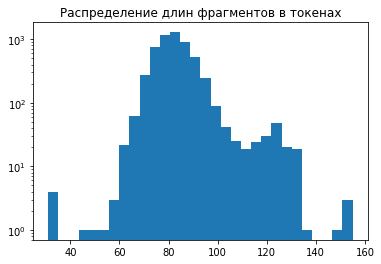

In [16]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

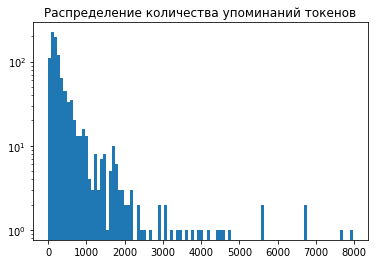

In [17]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [18]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0


## Подготовка датасетов для PyTorch

In [19]:
CHUNK_LENGTH = 80

#формируем датасеты на основе исходных последовательностей BPE (с разбросом длины примерно от 40 до 160), 
#на примере запроса одного элемента, они будут возвращать:
#2 шт. numpy array (seed_part, target_part), длины 80, состоящие из id токенов, где токены в target_part,
#смещены на 1 вперед, относительно seed_part, кроме того:
# - если длина изначальной BPE последовательности > CHUNK_LENGTH, то итоговая последовательность вырезается
#   в объеме CHUNK_LENGTH из рандомного места (не сначала)
# - если длина изначальной BPE последовательности < CHUNK_LENGTH, то берется вся исходная и добивается справа 
#   паддингами до длины CHUNK_LENGTH
train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

In [20]:
train_dataset[0]

(array([  2, 477, 341, 188, 243,  83, 558, 355, 336, 485, 475, 305,  21,
        153, 301, 596, 183, 232, 244, 367,   8, 447, 149, 200, 261, 191,
        620,   6, 159, 276, 985, 191, 475, 622, 482, 455, 159, 153, 149,
        279, 657, 705, 397,   8, 175, 445,  10, 188, 673, 200,  10, 175,
        167, 887, 658, 149, 367, 162, 362, 417, 155, 261, 153, 658, 207,
        314, 185, 196, 292, 152,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]),
 array([477, 341, 188, 243,  83, 558, 355, 336, 485, 475, 305,  21, 153,
        301, 596, 183, 232, 244, 367,   8, 447, 149, 200, 261, 191, 620,
          6, 159, 276, 985, 191, 475, 622, 482, 455, 159, 153, 149, 279,
        657, 705, 397,   8, 175, 445,  10, 188, 673, 200,  10, 175, 167,
        887, 658, 149, 367, 162, 362, 417, 155, 261, 153, 658, 207, 314,
        185, 196, 292, 152,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]))

In [21]:
tokenizer.decode(list(train_dataset[0]))

['<BOS> ревался объехать все свои именья и лично удостовериться в том, что сделано из того, что им предписано и в каком положении находится теперь тот народ, который вверен ему Богом, и который он стремился о<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>',
 'ревался объехать все свои именья и лично удостовериться в том, что сделано из того, что им предписано и в каком положении находится теперь тот народ, который вверен ему Богом, и который он стремился о<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']

## Общие классы и функции

### Маска зависимостей

In [22]:
def make_target_dependency_mask(length):
    full_mask = torch.ones(length, length)
    ignore_mask = torch.tril(full_mask) < 1
    full_mask.masked_fill_(ignore_mask, float('-inf'))
    full_mask.masked_fill_(~ignore_mask, 0)
    return full_mask

make_target_dependency_mask(10)

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Кодирование позиции

In [23]:
def make_positional_encoding(max_length, embedding_size):
    time = np.pi * torch.arange(0, max_length).float()
    freq_dividers = torch.arange(1, embedding_size // 2 + 1).float()
    inputs = time[:, None] / freq_dividers[None, :]
    
    result = torch.zeros(max_length, embedding_size)
    result[:, 0::2] = torch.sin(inputs)
    result[:, 1::2] = torch.cos(inputs)
    return result

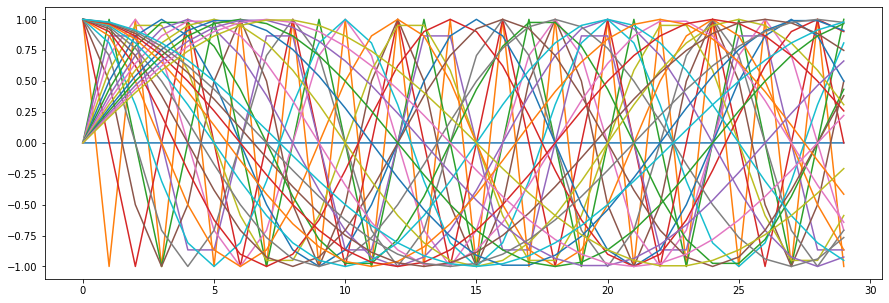

In [24]:
sample_pos_codes = make_positional_encoding(30, 30)
plt.plot(sample_pos_codes[:,:].numpy());
plt.gcf().set_size_inches((15, 5))

### Основной класс - языковая модель

In [25]:
class LanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, backbone, emb_dropout=0.0):
        super().__init__()
        self.embedding_size = embedding_size
        self.embeddings = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        self.emb_dropout = nn.Dropout(emb_dropout)
        self.backbone = backbone
        self.out = nn.Linear(embedding_size, vocab_size)
    
    def forward(self, seed_token_ids):
        """
            seed_token_ids - BatchSize x MaxInLen
        """
        batch_size, max_in_length = seed_token_ids.shape

        #padding mask - тензор той же размерности, на позициях токенов с id=0 - True, иначе False
        seed_padding_mask = seed_token_ids == 0
        #квадратная маска зависимостей (выше главной диагонали -inf, на остальных позициях 0)
        dependency_mask = make_target_dependency_mask(max_in_length) \
            .to(seed_token_ids.device)
        
        #преобразовываем ids токенов в соответствующие им эмбеддинги
        seed_embs = self.embeddings(seed_token_ids)  # BatchSize x MaxInLen x EmbSize
        #генерируем позиционные коды (на основе sin/cos с разными периодами)
        pos_codes = make_positional_encoding(max_in_length,
                                             self.embedding_size).unsqueeze(0).to(seed_embs.device)
        seed_embs = seed_embs + pos_codes
        seed_embs = self.emb_dropout(seed_embs)

        #в роли backbone (суть/основа) выступает Transformer Encoder
        # BatchSize x TargetLen x EmbSize (размерность не изменяется)
        target_features = self.backbone(seed_embs,
                                        mask=dependency_mask,
                                        src_key_padding_mask=seed_padding_mask)
        #возвращаем logits для каждой позиции, для каждого токена из словаря
        logits = self.out(target_features)  # BatchSize x TargetLen x VocabSize
        return logits

### Утилиты для обучения - функция потерь и расписание изменения длины градиентного шага

In [26]:
def lm_cross_entropy(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])  # BatchSize*TargetLen x VocabSize
    target_flat = target.view(-1)  # BatchSize*TargetLen
    return F.cross_entropy(pred_flat, target_flat, ignore_index=0)


def lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                      patience=10,
                                                      factor=0.5,
                                                      verbose=True)

## Реализация Transformer из PyTorch 1.2

In [27]:
class BatchFirstTransformerEncoder(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        #TransformerEncoder is a stack of N encoder layers
        self.impl = nn.TransformerEncoder(*args, **kwargs)
        self.initialize_weights()
    
    def forward(self, src, *args, **kwargs):
        src = src.transpose(0, 1).contiguous()  # MaxInLen  x BatchSize x EmbSize
        result = self.impl(src, *args, **kwargs)  # TargetLen x BatchSize x EmbSize
        result = result.transpose(0, 1).contiguous()  # BatchSize x TargetLen x EmbSize
        return result
    
    def initialize_weights(self):
        for param in self.impl.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Генерация текста с помощью языковой модели

### Жадная генерация

### Генерация с помощью лучевого поиска - Beam Search

## Собственная реализация MultiHeadAttention

In [28]:
def my_multihead_attention(queries, keys, values,
                           keys_padding_mask, dependency_mask,
                           is_training,
                           weights_dropout):
    """
    queries - BatchSize x QueriesLen x HeadN x QuerySize
    keys - BatchSize x KeysLen x HeadN x KeySize
    values - BatchSize x ValuesLen x HeadN x ValueSize
    keys_padding_mask - BatchSize x KeysLen
    dependency_mask - QueriesLen x KeysLen
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x ValuesLen x HeadN x ValueSize - resulting features
        - BatchSize x QueriesLen x KeysLen x HeadN - attention map
    
    Выше размеры приведены для общего вида, и показывают суть, вариант размеров
    ниже более нагляден в плане самих реально используемых размеров:
    queries - BatchSize x Len x HeadN x ModelSize/HeadsN
    keys - BatchSize x Len x HeadN x ModelSize/HeadsN
    values - BatchSize x Len x HeadN x ModelSize/HeadsN
    keys_padding_mask - BatchSize x Len
    dependency_mask - Len x Len
    is_training - bool
    weights_dropout - float
    
    result - tuple of two:
        - BatchSize x Len x HeadN x ModelSize/HeadsN - resulting features
        - BatchSize x Len x Len x HeadN - attention map
    """

    #Используем (исключительно для наглядности) функцию Эйнштейновского перемножения, хотя,
    #хотя в видеолекции говориться, что именно скорей всего это перемножение сказывается на 
    #скорости вычислений наиболее сильно (в итоге наша реализация в 2-3 раза медленнее по времени),
    #перемножение происходит по измерению, отсутствующему в результате (после ->), в нашем случае
    #это последнее измерение, а именно размерности ModelSize/HeadsN
    #P.S. на самом деле я проводил эксперимент и существенная разница в скорости в обычной операции 
    #и через torch.einsum есть только на "игрушечных" тензорах, на сколько-нибудь соизмеримых с
    #реальными, эта разница стремиться к 0, т.к. мы скорей всего имеем накладные расходы только
    #для интерпретации представления в реальные операции, и на небольших тензорах, эта интерпретация,
    #занимает время, сопоставимое с самими операциями над тензором, в то время как на больших тензорах 
    #эти накладные расходы становятся несущественными в сравнении со временем на сами операции, т.е.
    #разница в 2-3 раза в скорости обучения моделей (самописной и из торча) видимо не в torch.einsum
    #
    #Получаем матрицу релевантности (в на презентациях из видеолекций, эта матрица называется 
    #называется logits, ее суть отразить схожесть каждого токена с каждым токеном, мерой схожести
    #выступает скалярное произведение соответсвующих токенов эмбеддингов (при этом размерность 
    #эмбеддингов = ModelSize/HeadsN), количество критериев, по которым вычисляется схожесть, 
    #и есть по сути число голов, т.е. в каждой голове по одному критерию), путем перемножения 
    #матриц queries на keys.T для каждой из голов.
    #Итого, на выходе для каждой из голов мы должны получить квадратные матрицы, 
    #размера Len x Len, кроме того мы заодно перераспределяем размерности в нужном нам порядке:
    # BatchSize x QueriesLen x KeysLen x HeadN
    # (для нашего случая на выходе имеем: BatchSize x Len x Len x HeadN)
    relevances = torch.einsum('bqhs,bkhs->bqkh', (queries, keys))
    
    # замаскировать элементы, выходящие за длины последовательностей ключей
    # позиции попадающие под маску будут заменены на -inf
    padding_mask_expanded = keys_padding_mask[:, None, :, None].expand_as(relevances)
    relevances.masked_fill_(padding_mask_expanded, float('-inf'))
    
    # замаскировать пары <выходная позиция, входная позиция> 
    #(т.е. для измерений QueriesLen x KeysLen), напомним:
    #в dependency_mask выше главной диагонали находятся -inf, на остальных позициях 0
    relevances = relevances + dependency_mask[None, :, :, None].expand_as(relevances)
    
    #нормируем через softmax
    normed_rels = F.softmax(relevances, dim=2)
    normed_rels = F.dropout(normed_rels, p=weights_dropout, training=is_training)
    
    #цель оставшихся вычислений, это эффективная реализации матричного произведения по 
    #каждой голове, полученных нормированных релевантностей, на head values, после чего,
    #конкатинация полученных матриц по измерению урезанных эмбеддингов в единую "матрицу", 
    #где размерность векторов эмбеддингов будет исходной длины
    
    # BatchSize x ValuesLen x KeysLen x HeadN x 1
    #(для нашего случая: BatchSize x Len x Len x HeadN x 1)
    normed_rels_expanded = normed_rels.unsqueeze(-1)
    
    # BatchSize x 1 x KeysLen x HeadN x ValueSize
    values_expanded = values.unsqueeze(1)
    
    # BatchSize x ValuesLen x KeysLen x HeadN x ValueSize
    weighted_values = normed_rels_expanded * values_expanded
    result = weighted_values.sum(2)  # BatchSize x ValuesLen x HeadN x ValueSize
    
    #кроме результата, для целей визуализации/интерпретации возвращаем еще и норм. релевантности
    return result, normed_rels

## Self-Attention - это Attention, в котором ключи, значения и запросы вычисляются из элементов одной и той же последовательности

In [29]:
class MyMultiheadSelfAttention(nn.Module):
    '''
    Реализация Multihead Self-Attention
    
    Примечания:
        - model_size - по сути EmdeddingSize (в baseline = 256)
        - n_heads - число голов, при этом model_size должно без остатка делиться на n_heads,
          (в baseline = 16)
        - в forward, помимо батча 
          последовательностей, передаются маска зависимостей и маска паддингов
    '''
    def __init__(self, model_size, n_heads, dropout=0):
        super().__init__()
        assert model_size % n_heads == 0, 'Размерность модели должна делиться нацело на количество голов'
        self.n_heads = n_heads
        #не забываем что внутри линейного слоя по сути матрица размером in_size x out_size (в данном случае,
        #это квадратная матрица, размера model_size x model_size + bias), при передаче в линейный слой тензора
        #в котором > 1 измерения, преобразования (перемножение на матрицу) происходит только по последнему 
        #измерению (это равносильно тому, что мы каждый эмбеддинг вектор из нашего входа, перемножим с квадратной 
        #матрицей + bias, получив на выходе аналогичные вектора такого же размера, после чего соберем их все 
        #в аналогичный тензор), итого, на выходе мы получим на 3 линейно преобразованных тензора исходной 
        #размерности, т.е. тензора queries, keys, values
        self.queries_proj = nn.Linear(model_size, model_size)
        self.keys_proj = nn.Linear(model_size, model_size)
        self.values_proj = nn.Linear(model_size, model_size)
        
        self.dropout = dropout

        self.last_attention_map = None
    
    def forward(self, sequence, padding_mask, dependency_mask):
        """
        sequence - BatchSize x Len x ModelSize(=EmbSize)
        padding_mask - BatchSize x Len
        dependency_mask - Len x Len
        
        result - BatchSize x Len x ModelSize
        """
        batch_size, max_len, model_size = sequence.shape
        
        #на примере квадратной матрицы (без измерения батча), мы сначала всю ее линейно преобразоываем,
        #на выходе получаем аналогичную размерность, а далее уже бьем на головы, добавляя дополнительное измерение
        #в итоге последнее измерение будет размера ModelSize(=EmbSize)/n_heads, что нам и нужно
        queries_flat = self.queries_proj(sequence)  # BatchSize x Len x ModelSize
        queries = queries_flat.view(batch_size, max_len, self.n_heads, -1) # BatchSize x Len x HeadsN x ModelSize/HeadsN
        
        keys_flat = self.keys_proj(sequence)  # BatchSize x Len x ModelSize
        keys = keys_flat.view(batch_size, max_len, self.n_heads, -1) # BatchSize x Len x HeadsN x ModelSize/HeadsN
        
        values_flat = self.values_proj(sequence)  # BatchSize x Len x ModelSize
        values = values_flat.view(batch_size, max_len, self.n_heads, -1) # BatchSize x Len x HeadsN x ModelSize/HeadsN
        
        # BatchSize x Len x HeadsN x ModelSize/HeadsN
        # подробное описание работы функции в ее коде
        result, att_map = my_multihead_attention(queries, keys, values,
                                                 padding_mask, dependency_mask,
                                                 self.training, self.dropout)
        result_flat = result.view(batch_size, max_len, model_size)
        
        self.last_attention_map = att_map.detach()

        return result_flat

## Один слой трансформера - Self-Attention, Feed-Forward, skip-connections, LayerNorm

In [30]:
class MyTransformerEncoderLayer(nn.Module):
    '''
    Реализует один слой энкодера (в трансформере таких слоев заданное количество, 
    батч последовательностей и маски, передаются через них последовательно, т.е. 
    выходы предыдущего слоя попадают на вход следующему и т.д.)
    Слой энкодера состоит из (в порядке следования):
        - один объект Multihead Self-Attention (с заданным количеством голов)
        - дропаут для выходов (Multihead Self-Attention), который складывается с 
          изначальными входами (батч последовательностей), реализуя Skip-Connection
        - первая нормализация через nn.LayerNorm
        - объект feed-forward, представляющий из себя последовательность (nn.Sequential)
          из 2-х линейных преобразований (с последующими дропаутами после каждого), между
          которыми для нелинейности находится nn.ReLU, размерность линейных преобразований
          задается через dim_feedforward, на входе в первый линейный слой и на выходе из 
          второго, размерность сохраняется (=model_size), почледовательность пропускается 
          через feed-forward, так же через Skip-Connection
        - по итогу проводим повторную нормализацию, так же через nn.LayerNorm
    Примечания:
        - model_size - по сути EmdeddingSize (в baseline = 256)
        - n_heads - число голов, при этом model_size должно без остатка делиться на n_heads,
          (в baseline = 16)
        - dim_feedforward в baseline = 512
        - в forward (текущего класса и подкласс Multihead Self-Attention), помимо батча 
          последовательностей, передаются маска зависимостей и маска паддингов
        
    '''
    def __init__(self, model_size, n_heads, dim_feedforward, dropout):
        super().__init__()
        self.self_attention = MyMultiheadSelfAttention(model_size,
                                                       n_heads,
                                                       dropout=dropout)
        self.first_dropout = nn.Dropout(dropout)
        self.first_norm = nn.LayerNorm(model_size)
        
        self.feedforward = nn.Sequential(
            nn.Linear(model_size, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, model_size),
            nn.Dropout(dropout)
        )
        self.second_norm = nn.LayerNorm(model_size)
    
    def forward(self, sequence, padding_mask, dependency_mask):
        att_features = self.self_attention(sequence, padding_mask, dependency_mask)

        sequence = sequence + self.first_dropout(att_features)
        sequence = self.first_norm(sequence)
        
        sequence = sequence + self.feedforward(sequence)
        sequence = self.second_norm(sequence)
        return sequence

## Энкодер Трансформера - стопка из нескольких слоёв

In [31]:
class MyTransformerEncoder(nn.Module):
    '''
    #верхнеуровневый класс энкодера, функционал:
        - собирает последовательно (в ходе forward, выходы предыдущего слоя передаются в следующий и т.д.)
          несколько слоев энкодера (в количестве n_layers), с передачей им параметров layer_kwargs
        - в forward (текущего класса и слои енкодера), помимо батча последовательностей,
          передаются маски зависимостей (т.е. сдвигов) и паддингов (что бы не учитывать их)
        - во время создания, инициализирует веса через nn.init.xavier_uniform_(param)
    '''
    
    def __init__(self, n_layers, **layer_kwargs):
        super().__init__()
        self.layers = nn.ModuleList([
            MyTransformerEncoderLayer(**layer_kwargs)
            for _ in range(n_layers)
        ])
        self.initialize_weights()

    def forward(self, sequence, mask, src_key_padding_mask):
        for layer in self.layers:
            sequence = layer(sequence, src_key_padding_mask, mask)
        return sequence

    def initialize_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

## Попробуем обучить языковую модель с нашим Трансформером

## Наша реализация - жадная генерация

## Визуализация карт внимания

# Итоговое задание семинара 4.6.Final

In [32]:
'''
Итоговые пунткты для меня:
    + перенести весь необходимый для запуска семинара код dlnlputils (с учетом моих ранее проиизведенных модификаций) в ячейки ноутбука, дополнить 
      моими наработками, на выходе код семинара должен запускаться без импорта dlnlputils
    + проанализировать и понять код семинара (если нужно, добавить развернутые комментарии)
    + Примечания по коду, которые возможно стоит проанализировать с целью изменения (улучшения результатов):
        + Очень странно мы проставляем теги начала и конца последовательности, т.к. у нас последовательности начинаются/оканчиваются обрывками слов, 
          фраз, предложений и т.д., то какой они будут нести смысл абсолютно непонятно. (после CHUNK_LENGTH=80 возможно смысл еще более теряется) -->
          анализ проведен, добавлен отдельный пункт в задачи
    + поменять параметры beam search (beamsize, return_hypotheses_n и т.д.)
        + т.к. модели учаться долго, то пользоваться тем, что можно подгружать сохраненные на прошлых запусках модели
        + не понимаю почему мы вычитаем token_score из текущего logita, а не прибавляем к нему -> разобраться
        + поразмыслить над этим "if len(partial_hypotheses) > beamsize: ...", подробный коментарий в коде, проследить с
        + beamsize/return_hypotheses_n
        + проследить как изменяются нормализованные и ненормализованные вероятности для каждой позиции на примере нескольких последовательностей
        + разные варианты нормализации (убрать, изменить и т.д.)
    + Изменить подход по жесткой разбивке на чанки по 200 символов (при этом на концах обрывки фраз, далее еще проставляются теги начала/конца предложений):
        + токенизация по предложениям (нескольким, сколько поместится в 200 символов), или по абзацам
    + поиграться с параметрами и архитектурой (количество self-attention модулей, количество голов в MultiHead attention и т.д.)
        + количество self-attention слоев (6)
        + количество голов в MultiHead attention (128)
        + размер эмбеддингов (512)
        + emb_dropout, очень значимый дропаут (0.0 / 0.4)
    - применить модель(-и) из данного семинара (трансформер) к прошлой задаче по генерации цитат через RNN (проанализировать и сравнить результаты) (без BPE)
    - применить модель(-и) из данного семинара (трансформер) ко всем имеющимся текстам Кови из семинара про word2vec (посмотреть что получится)
''';

### Эксперименты с beam search 

### Эксперименты с более нормальной разбивкой датасета на куски (chunk)

### Эксперименты с параметрами и архитектурой

In [33]:
histories = {}

In [34]:
#hyperparameters
exp_name = 'baseline_epoch_n=10'
hyps = {
    #LanguageModel
    'emb_size': 256,
    'emb_dropout': 0.1, #очень значимый дропаут
    
    #TransformerEncoder
    'nhead': 16,
    'dim_feedforward': 512,
    'enc_dropout': 0.1,
    'num_enc_layers': 3,

    #train_eval_loop
    'lr': 2e-3,
    'epoch_n': 10,
    'batch': 256,
    'device': 'cuda',
    'stop_pat': 25,
    'lr_sched_pat': 15,
    'lr_sched_fac': 0.5
}

histories[exp_name] = {
    'hyps': hyps
}

torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   hyps['emb_size'], #EmbSize
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=hyps['emb_size'], #EmbSize
                                           nhead=hyps['nhead'],
                                           dim_feedforward=hyps['dim_feedforward'],
                                           dropout=hyps['enc_dropout']),
                                       num_layers=hyps['num_enc_layers']),
                                   emb_dropout=hyps['emb_dropout'])
print('Количество параметров', get_params_number(torch_transf_model))

(histories[exp_name]['train_history'],
 histories[exp_name]['best_model']) = train_eval_loop(torch_transf_model,
                                                train_dataset,
                                                test_dataset,
                                                lm_cross_entropy,
                                                lr=hyps['lr'],
                                                epoch_n=hyps['epoch_n'],
                                                batch_size=hyps['batch'],
                                                device=hyps['device'],
                                                early_stopping_patience=hyps['stop_pat'],
                                                max_batches_per_epoch_train=1000,
                                                max_batches_per_epoch_val=1000,
                                                experiment_name = exp_name,
                                                lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                                                  patience=hyps['lr_sched_pat'],
                                                                                  factor=hyps['lr_sched_fac'],
                                                                                  verbose=True),
                                                no_calculate_accuracy = True)


Количество параметров 2094312
############## Start experiment with name: baseline_epoch_n=10 ##############
Epoch =   1,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 6.2418, train = 6.3316   SAVE: True, Iters: 21, Time: 3.91s
Epoch =   2,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 5.9342, train = 6.1716   SAVE: True, Iters: 21, Time: 2.83s
Epoch =   3,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 5.0143, train = 5.5829   SAVE: True, Iters: 21, Time: 2.84s
Epoch =   4,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.4740, train = 4.7794   SAVE: True, Iters: 21, Time: 2.94s
Epoch =   5,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.2579, train = 4.3908   SAVE: True, Iters: 21, Time: 2.89s
Epoch =   6,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.1111, train = 4.1965   SAVE: True, Iters: 21, Time: 2.84s
Epoch =   7,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.9845, train = 4.0460   SAVE: True, Iters: 21, Time: 2.83s
Epoch =   8,   ACC: val 

In [35]:
#hyperparameters
exp_name = 'baseline_epoch_n=20'
hyps = {
    #LanguageModel
    'emb_size': 256,
    'emb_dropout': 0.1, #очень значимый дропаут
    
    #TransformerEncoder
    'nhead': 16,
    'dim_feedforward': 512,
    'enc_dropout': 0.1,
    'num_enc_layers': 3,

    #train_eval_loop
    'lr': 2e-3,
    'epoch_n': 20,
    'batch': 256,
    'device': 'cuda',
    'stop_pat': 25,
    'lr_sched_pat': 15,
    'lr_sched_fac': 0.5
}

histories[exp_name] = {
    'hyps': hyps
}

torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   hyps['emb_size'], #EmbSize
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=hyps['emb_size'], #EmbSize
                                           nhead=hyps['nhead'],
                                           dim_feedforward=hyps['dim_feedforward'],
                                           dropout=hyps['enc_dropout']),
                                       num_layers=hyps['num_enc_layers']),
                                   emb_dropout=hyps['emb_dropout'])
print('Количество параметров', get_params_number(torch_transf_model))

(histories[exp_name]['train_history'],
 histories[exp_name]['best_model']) = train_eval_loop(torch_transf_model,
                                                train_dataset,
                                                test_dataset,
                                                lm_cross_entropy,
                                                lr=hyps['lr'],
                                                epoch_n=hyps['epoch_n'],
                                                batch_size=hyps['batch'],
                                                device=hyps['device'],
                                                early_stopping_patience=hyps['stop_pat'],
                                                max_batches_per_epoch_train=1000,
                                                max_batches_per_epoch_val=1000,
                                                experiment_name = exp_name,
                                                lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                                                  patience=hyps['lr_sched_pat'],
                                                                                  factor=hyps['lr_sched_fac'],
                                                                                  verbose=True),
                                                no_calculate_accuracy = True)


Количество параметров 2094312
############## Start experiment with name: baseline_epoch_n=20 ##############
Epoch =   1,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 6.2403, train = 6.3284   SAVE: True, Iters: 21, Time: 2.98s
Epoch =   2,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 5.9050, train = 6.1520   SAVE: True, Iters: 21, Time: 2.90s
Epoch =   3,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.9300, train = 5.4950   SAVE: True, Iters: 21, Time: 2.83s
Epoch =   4,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.4614, train = 4.7335   SAVE: True, Iters: 21, Time: 2.84s
Epoch =   5,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.2544, train = 4.3804   SAVE: True, Iters: 21, Time: 2.84s
Epoch =   6,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.1120, train = 4.1958   SAVE: True, Iters: 21, Time: 2.91s
Epoch =   7,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.9880, train = 4.0501   SAVE: True, Iters: 21, Time: 2.83s
Epoch =   8,   ACC: val 

#### Итоги экспериментов

baseline_epoch_n=10---------------------------------------------------------------------------------
Max val acc on:    Epoch =   0,   ACCURACY: val  = 0.0000, train = 0.0000,   LOSS: val  = inf, train = inf
Min val loss on:   Epoch =  10,   ACCURACY: val  = 0.0000, train = 0.0000,   LOSS: val  = 3.7171, train = 3.7036
baseline_epoch_n=20---------------------------------------------------------------------------------
Max val acc on:    Epoch =   0,   ACCURACY: val  = 0.0000, train = 0.0000,   LOSS: val  = inf, train = inf
Min val loss on:   Epoch =  20,   ACCURACY: val  = 0.0000, train = 0.0000,   LOSS: val  = 3.3730, train = 3.1137


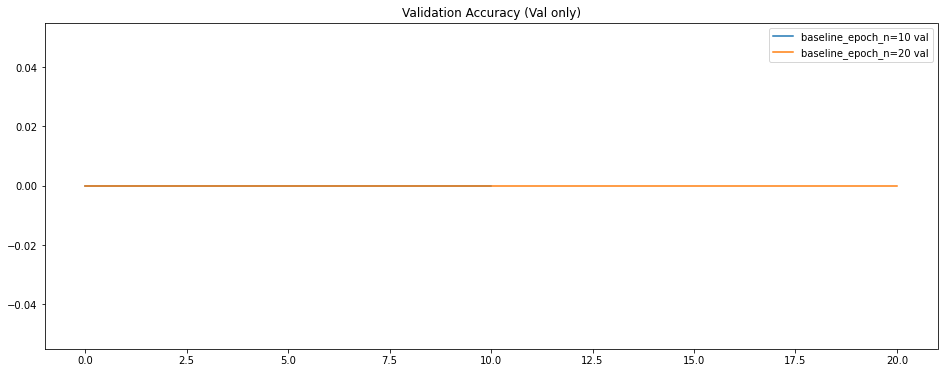

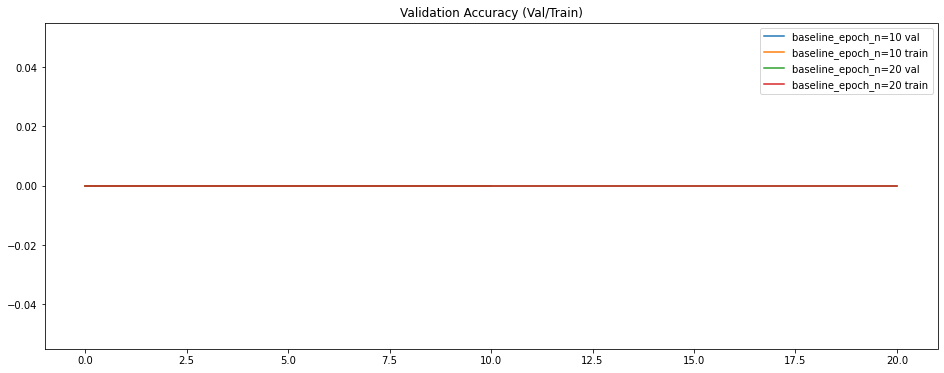

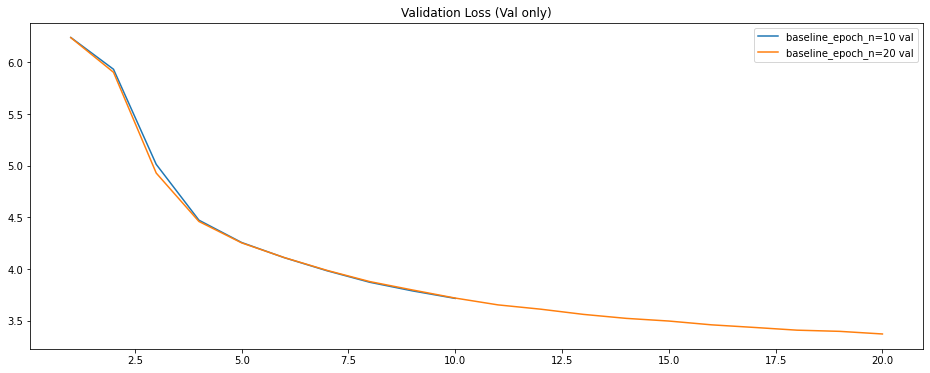

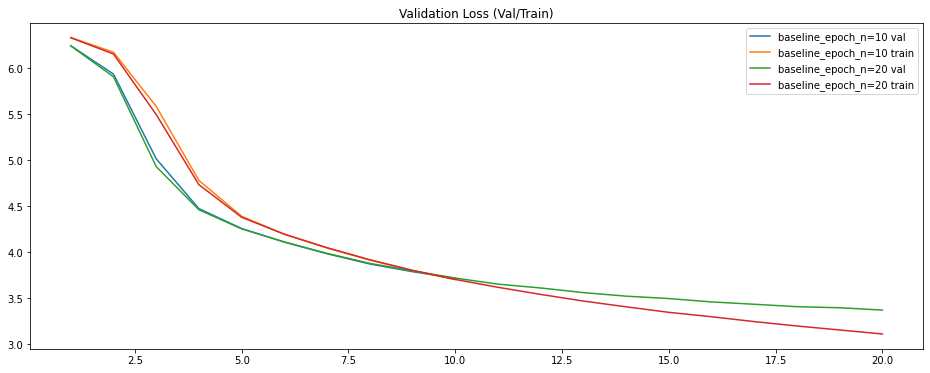

In [36]:
#show_general_experiments_stats
train_history = {}
for exp_name, exp in histories.items():
    if 'train_history' in exp:
        train_history[exp_name] = exp['train_history']
show_experiments_stats(train_history, show_plots = True, only_BEST_MODEL_CALC = False)

In [37]:
for exp_name in histories:
    print('{:-<100}'.format(exp_name))
    print('')
    greedy_generator = GreedyGenerator(histories[exp_name]['best_model'], tokenizer, device=GLOBAL_DEVICE)
    print(greedy_generator('сказала княжна, оглядывая Бона'))
    print(greedy_generator('смеялась княжна, оглядывая Наполе'))
    print(greedy_generator('сказала княжна, оглядывая Кутуз'))
    print(greedy_generator('сказал Кутузов, оглядывая Наполеона'))
    print('')
    print('')

baseline_epoch_n=10---------------------------------------------------------------------------------

сказала княжна, оглядывая Бонапарте. - C'est un hatichatiche hatien, rechaliche
смеялась княжна, оглядывая Наполеон. - C'est camiche hechautiche he heur homment hom
сказала княжна, оглядывая Кутузу и на него. - C'est ce plusse homment homment homment heur homment
сказал Кутузов, оглядывая Наполеона с ним и с ним и с ним несколько времени, и не было, что он не успел находится вместе свете лицо, и не


baseline_epoch_n=20---------------------------------------------------------------------------------

сказала княжна, оглядывая Бонапарте. - Celase se se se pour vous aidien, 16 - сказала она. - C'est cel
смеялась княжна, оглядывая Наполеона. - C'est un homme revellez, 15 - сказал князь Андрей. - C'est un homme demi
сказала княжна, оглядывая Кутузвую руку. - Я не понимаю, - сказал князь Андрей. - Я не понимаю, - сказал Пьер, что вы не понимаю, - что вы не понимаю, что вы
сказал Кутузов, ог

In [38]:
for exp_name in histories:
    print('{:-<100}'.format(exp_name))
    print('')
    my_beam_generator = myBeamGenerator(histories[exp_name]['best_model'], tokenizer, device=GLOBAL_DEVICE)
    beam_gen_variants = my_beam_generator('сказала княжна, оглядывая Наполе',
                                       beamsize=20,
                                       max_steps_n=80,
                                       return_hypotheses_n=8,
                                       norm='sqrt_len')

    for score, pred_txt in beam_gen_variants:
        print('****')
        print(score)
        print(pred_txt)
        print()
    print('')
    print('')

baseline_epoch_n=10---------------------------------------------------------------------------------

****
7.400020476391084
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисов<EOS>

****
7.667170387197166
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисов. - Хорошо, - сказала графин<EOS>

****
7.80863107903018
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисов. - Хорошо, - сказал Билибин<EOS>

****
7.810622200997403
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисову, - кричал Денисов<EOS>



In [39]:
for exp_name in histories:
    print('{:-<100}'.format(exp_name))
    print('')
    my_beam_generator = myBeamGenerator(histories[exp_name]['best_model'], tokenizer, device=GLOBAL_DEVICE)
    beam_gen_variants = my_beam_generator('сказала княжна, оглядывая Наполе',
                                       beamsize=20,
                                       max_steps_n=80,
                                       return_hypotheses_n=8,
                                       norm='nonorm')

    for score, pred_txt in beam_gen_variants:
        print('****')
        print(score)
        print(pred_txt)
        print()
    print('')
    print('')

baseline_epoch_n=10---------------------------------------------------------------------------------

****
61.913013281300664
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисов<EOS>

****
67.64197245426476
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисову, - кричал Денисов<EOS>

****
67.87613839097321
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисов, - кричал Денисов<EOS>

****
68.4166840929538
сказала княжна, оглядывая Наполеона Марья Дмитриевна Марья Дмитриевна Марья Дмитриевна. - Хорошо! - закричал Денисов, - закричал Денисов, - закричал Денисов, - закричал Денисову, - крик<EOS>

****
68.53949633426964
сказа

### Эксперимент применить трансформер ко всем имеющимся текстам Кови из семинара про word2vec

In [40]:
import random
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F

from nltk.tokenize import sent_tokenize, word_tokenize

In [41]:
BOOK_DIRNAME = '/kaggle/input/my-private-datasets/CVBooks/rus/'
BOOK_LANGUAGE='russian'
corpus_paragraphs = []
for _, _, filenames in os.walk(BOOK_DIRNAME):
    for filename in filenames:
        #print(os.path.join(BOOK_DIRNAME, filename))
        with open(os.path.join(BOOK_DIRNAME, filename)) as file:
            corpus_paragraphs.extend([line.strip() for line in file])
            
corpus_paragraphs = list(filter(None, corpus_paragraphs)) #remove empty strings
print(len(corpus_paragraphs))
corpus_paragraphs[200:205]

28922


['Тружусь ли я именно над тем результатом — окончанием повести, которого желаю?',
 'Парадигма 2: «я вижу тебя»',
 'Смысл второй парадигмы — видеть в других людях людей, а не вещи.',
 'Что мы видим, когда смотрим на других? Видим ли мы личность или просто обращаем внимание на возраст, пол, расу, политические и религиозные убеждения, физические или умственные ограничения, национальность, сексуальную ориентацию? Видим ли мы индивида, находящегося «вне группы» или «внутри группы»? Или же мы действительно видим уникальность, возможности, дарования каждого отдельного человека?',
 'Возможно, мы на самом деле вообще не смотрим на людей так часто, как на собственные представления о них, предвзятые мнения или даже предпочтения.']

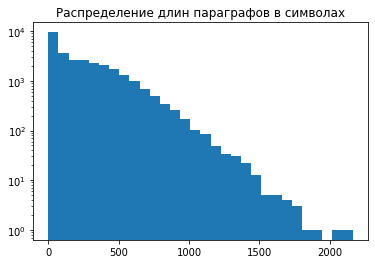

In [42]:
texts = corpus_paragraphs
plt.hist([len(line) for line in texts], bins=30)
plt.title('Распределение длин параграфов в символах')
plt.yscale('log');

In [43]:
#токенизируем по предложениям
from nltk import tokenize
sent_corpus = tokenize.sent_tokenize(' '.join(texts))
sent_corpus[100:110]

['Так разгорается лихорадка раздоров, и мы действительно рискуем заболеть.',
 '«Меня глубоко беспокоит то, как вся наша культура демонизирует Другого… Худшие эпохи человеческой истории начинались именно с этого — с негативизма в адрес инаковости.',
 'А дальше скатывались в жес\xadтокий экстремизм», — говорит специалист по охране здоровья Элизабет Лессер3.',
 'Мы слишком хорошо знаем, к чему все это приводит.',
 'Итак, что позволит нам урегулировать конфликты и разрешить самые сложные проблемы?',
 'Мы встаем на путь конфронтации, когда больше не будем чего-то терпеть, но станем отыгрываться на своих «врагах»?',
 'Мы изображаем жертву, пассивно дожидаясь спасителя?',
 'Мы доводим идею позитивного мышления до абсурда, в безграничном благодушии просто отрицая проблемы?',
 'Мы сидим сиднем и стоически терпим проблемы, даже не надеясь, что они когда-нибудь разрешатся?',
 'Иначе говоря, фактически пребываем в убеждении, что любые рекомендации о том, как нам наладить свою жизнь, — не более чем

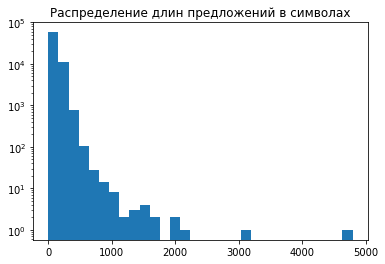

In [44]:
plt.hist([len(line) for line in sent_corpus], bins=30)
plt.title('Распределение длин предложений в символах')
plt.yscale('log');

In [45]:
#раpбиваем на чанки не более заданной длины, причем чанки должны состоять 
#из цельных предложений, а не кусков, чанки перекрывают друг друга со 
#со сдвигом в одно предложение
#если предложение длинне макс. длины чанка, оно отбрасывается
chunk_size = 300
all_chunks = []
for i in range(len(sent_corpus)):
    if len(sent_corpus[i]) <= chunk_size:
        all_chunks.append(sent_corpus[i])
    else:
        continue
    j = 1
    while i+j < len(sent_corpus) and len(all_chunks[-1] + ' ' + sent_corpus[i+j]) <= chunk_size:
        all_chunks[-1] = all_chunks[-1] + ' ' + sent_corpus[i+j]
        j += 1

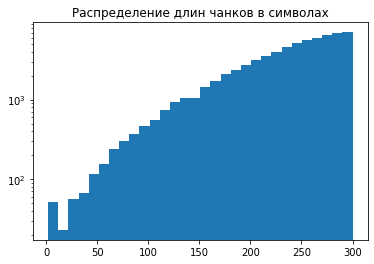

In [46]:
plt.hist([len(line) for line in all_chunks], bins=30)
plt.title('Распределение длин чанков в символах')
plt.yscale('log');

In [47]:
all_chunks[10:20]

['Джордж Льюис Синергия — деятельность самого высокого порядка; она создает новые неизведанные альтернативы; она обеспечивает оценку и применение умственных, эмоциональных и психологических различий между людьми. Стивен Кови Синергия возникает, когда целое превышает сумму его частей.',
 'Стивен Кови Синергия возникает, когда целое превышает сумму его частей. Ученик четвертого класса начальной школы A. B. Combs, г. Роли, Северная Каролина Моей жене и неизменному другу — Сандре, воплощению жизни, света и бесстрашной надежды Глава 1 Точка перехода Жизнь полна проблем.',
 'Ученик четвертого класса начальной школы A. B. Combs, г. Роли, Северная Каролина Моей жене и неизменному другу — Сандре, воплощению жизни, света и бесстрашной надежды Глава 1 Точка перехода Жизнь полна проблем. Проблем, кажущихся неразрешимыми. Личных проблем. Семейных проблем.',
 'B. Combs, г. Роли, Северная Каролина Моей жене и неизменному другу — Сандре, воплощению жизни, света и бесстрашной надежды Глава 1 Точка пере

In [48]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 48300
Размер валидационной выборки 20701


In [49]:
if not LOAD_SAVED_MODELS_MODE:
    # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
    TRAIN_TEXTS_FILENAME = './stepik-dl-nlp/datasets/covey.txt'
    save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
    
    !mkdir ./stepik-dl-nlp/models/
    BPE_MODEL_FILENAME = './stepik-dl-nlp/models/covey.yttm'

    # data: string, path to file with training data
    # model: string, path to where the trained model will be saved
    # vocab_size: int, number of tokens in the final vocabulary
    # coverage: float, fraction of characters covered by the model. Must be in the range [0, 1]. A good value to use is about 0.9999.
    # n_threads: int, number of parallel threads used to run. If -1 is passed, then all available threads are going to be used. 
    #     Note that the number of threads is limited by 8 (see benchmark).
    # pad_id: int, reserved id for padding
    # unk_id: int, reserved id for unknown symbols
    # bos_id: int, reserved id for begin of sentence token
    # eos_id: int, reserved id for end of sentence token
    yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);
else:
    #берем модель из предыдущего ноутбука
    BPE_MODEL_FILENAME = '/kaggle/input/stepik-nn-and-nlp-4-6-final-transformer-and-sa/stepik-dl-nlp/models/covey.yttm'

mkdir: cannot create directory ‘./stepik-dl-nlp/models/’: File exists


Training parameters
  input: ./stepik-dl-nlp/datasets/covey.txt
  model: ./stepik-dl-nlp/models/covey.yttm
  vocab_size: 1000
  n_threads: 2
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 180
number of deleted characters: 0
number of unique characters left: 180
model saved to: ./stepik-dl-nlp/models/covey.yttm


In [50]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [51]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о е и а т н с в р л м д к п у я ы ь , ч б з г . й ж х ю ш ц щ э В ф Н П » « О e ? — К – С - : М a o n И r i t Д Т s 1 Я Э Е 0 l А 2 ! Р h Ч Б d ) У ( c 9 u 3 m Л З Г p y g 5 / 4 7 I C 8 6 f w T • S k ъ v ; b A Х P M B L N H Ф W E R … F Ш D " G Ц J Ж Y O ] [ % V x Ь K z U Ю X ● Й _ Q “ ­ ё Ы * № & ' j } { ” = „ ’ q Z ́ ó $ © Щ + @ # × І á ö Ё > < ° ü ¸ ½ ® ` ▁с ▁п ▁в то ▁н ни ст но ▁и ▁о ра ре ро ко ▁д те ли ть ▁по ▁м ен ▁на го ва ль ▁ч ри ет ка во ны ▁не ем ла ени ▁б за на ся та ▁у ло ти да де ми ▁э ▁что ру ▁ко ве ди ви ле мо ▁ра ▁про ▁со ▁вы ля ▁к ▁за ▁от ци ▁при ки ▁до не ност ▁ка ▁об чи хо ▁то же бо ▁е ма ▁мо ей по ▁это сь ▁В ▁ва до жи ча ▁во лю ▁бы че ▁« ют ши лу ры се ▁Н ▁сво ения ▁П ▁я ме ги ста ▁ре ▁О ду си со сто ▁— га ну ▁из вы ▁– ▁де ▁а ▁т ение ▁пре ▁К ств сти зна тель ▁мы ше му ться м, ной ные щи ня ▁все ▁лю ер ▁та ▁те ▁раз ▁С ▁кото гда ▁М ▁дру ▁ли ▁ни ▁как ще ния ▁си па ту ных мен ности ность ▁бо це ется ку ▁го ере бы ного ▁И вать тив ▁са ство сть 

In [52]:
print(tokenizer.encode(train_texts[:1], bos=True, eos=True))

[[2, 370, 43, 49, 61, 56, 129, 66, 39, 56, 66, 328, 56, 39, 66, 72, 87, 56, 56, 497, 43, 85, 66, 144, 874, 296, 216, 235, 197, 762, 719, 335, 266, 555, 212, 206, 795, 713, 71, 665, 7, 200, 195, 340, 195, 203, 489, 737, 766, 343, 573, 229, 223, 9, 4, 880, 865, 361, 218, 206, 317, 232, 717, 31, 187, 216, 198, 188, 281, 31, 474, 244, 31, 194, 311, 272, 653, 232, 243, 800, 249, 288, 211, 202, 206, 518, 332, 454, 32, 766, 344, 23, 335, 206, 229, 208, 392, 185, 237, 584, 388, 255, 19, 208, 392, 305, 19, 38, 919, 3]]


In [53]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

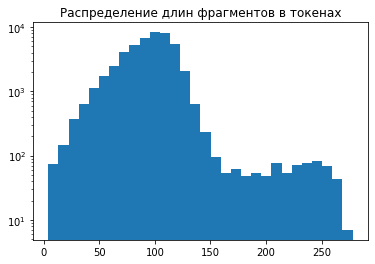

In [54]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

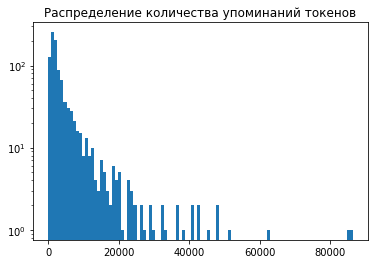

In [55]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [56]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 4


In [57]:
CHUNK_LENGTH = max(map(len,train_token_ids))
print('CHUNK_LENGTH = {}'.format(CHUNK_LENGTH))

#формируем датасеты на основе исходных последовательностей BPE (с разбросом длины примерно от 40 до 160), 
#на примере запроса одного элемента, они будут возвращать:
#2 шт. numpy array (seed_part, target_part), длины 80, состоящие из id токенов, где токены в target_part,
#смещены на 1 вперед, относительно seed_part, кроме того:
# - если длина изначальной BPE последовательности > CHUNK_LENGTH, то итоговая последовательность вырезается
#   в объеме CHUNK_LENGTH из рандомного места (не сначала)
# - если длина изначальной BPE последовательности < CHUNK_LENGTH, то берется вся исходная и добивается справа 
#   паддингами до длины CHUNK_LENGTH
train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

CHUNK_LENGTH = 278


In [58]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256, #EmbSize
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256, #EmbSize
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [59]:
if not LOAD_SAVED_MODELS_MODE:
    (best_val_loss,
     best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                                train_dataset,
                                                test_dataset,
                                                lm_cross_entropy,
                                                lr=2e-3,
                                                epoch_n=20,
                                                batch_size=192,
                                                device='cuda',
                                                early_stopping_patience=20,
                                                max_batches_per_epoch_train=1000,
                                                max_batches_per_epoch_val=1000,
                                                lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                                                  patience=10,
                                                                                  factor=0.5,
                                                                                  verbose=True),
                                                no_calculate_accuracy = True)

    # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
    torch.save(best_torch_transf_model.state_dict(), './stepik-dl-nlp/models/covey_torch_transf_best.pth')

#     # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
#     torch_transf_model.load_state_dict(torch.load('./stepik-dl-nlp/models/war_and_peace_torch_transf_best_v2.pth'))
else:
    if GLOBAL_DEVICE == 'cuda':
        #Используем сохраненную в предыдущей версии ноутбука ("Save Version") модель
        torch_transf_model.load_state_dict(torch.load('/kaggle/input/stepik-nn-and-nlp-4-6-final-transformer-and-sa/stepik-dl-nlp/models/covey_torch_transf_best.pth'))
    else:
        #Используем сохраненную в предыдущей версии ноутбука ("Save Version") модель
        torch_transf_model.load_state_dict(torch.load('/kaggle/input/stepik-nn-and-nlp-4-6-final-transformer-and-sa/stepik-dl-nlp/models/covey_torch_transf_best.pth', 
                                                  map_location=torch.device('cpu')))

############## Start experiment with name: NoName ##############
Epoch =   1,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.6333, train = 4.6007   SAVE: True, Iters: 251, Time: 125.82s
Epoch =   2,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.2309, train = 3.5889   SAVE: True, Iters: 251, Time: 125.71s
Epoch =   3,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.0630, train = 3.3344   SAVE: True, Iters: 251, Time: 126.03s
Epoch =   4,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 2.9596, train = 3.2044   SAVE: True, Iters: 251, Time: 125.87s
Epoch =   5,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 2.8982, train = 3.1193   SAVE: True, Iters: 251, Time: 125.90s
Epoch =   6,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 2.8407, train = 3.0605   SAVE: True, Iters: 251, Time: 125.98s
Epoch =   7,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 2.7994, train = 3.0139   SAVE: True, Iters: 251, Time: 125.86s
Epoch =   8,   ACC: val = 0.0000, train = 0.00

In [60]:
initial_sequences = [
    'Проактивность ',
    'Принципы это',
    'Добросовестность, мужество, служение, ',
    'Синергия, это ',
    'Миссия',
    '7'
]

In [61]:
#подробный комментарий по работе приведен в коде GreedyGenerator
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer, device=GLOBAL_DEVICE)

In [62]:
for init_seq in initial_sequences:
    print(greedy_generator(init_seq))

Проактивность. Решение. Представьте себе, что вы не можете сделать в своей жизни. Вы не будете слышать о том, что вы делаете. Вы
Принципы это навыка. Достигайте синергии Р/РС-баланса. Рольс и Р/РС-баланса. Реализация. Р
Добросовестность, мужество, служение, совесть, совесть и совесть. Жизнь — это то, что мы делаем, и есть. Мы можем быть более эффективными, более эффективными, более эффектив
Синергия, это не просто администрация. Но вместо того чтобы быть властью и внести свой вклад в общее дело.
Миссия вновят в нашу жизнь в нашу жизнь.
7 James HarperColllins, March, Welle World World


In [63]:
my_beam_generator = myBeamGenerator(torch_transf_model, tokenizer, device=GLOBAL_DEVICE)

In [64]:
for init_seq in initial_sequences:
    print('{:-<100}'.format(init_seq))
    beam_gen_variants = my_beam_generator(init_seq,
                                       beamsize=20,
                                       max_steps_n=160,
                                       return_hypotheses_n=20,
                                       norm='sqrt_len')

    for score, pred_txt in beam_gen_variants:
        print('****')
        print(score)
        print(pred_txt)
        print()
    print()
    print()

Проактивность --------------------------------------------------------------------------------------
****
3.177664050211509
Проактивность. Рис.<EOS>

****
10.686788119029496
Проактивность. Рис. П. 1. П. 1. Рис. П. 1. П. П. 1. П. 1. П. 1. П. П. 1. П. П. 1. Рис. П. 1. П. П. 1. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. Р. П. П. 1. П. П. П. 1. П. П. 1. П. П. П. П.

****
10.70139223033224
Проактивность. Рис. П. 1. П. 1. Рис. П. 1. П. П. 1. П. 1. П. 1. П. П. 1. П. П. 1. Рис. П. 1. П. П. 1. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. Р. П. П. 1. П. П. П. 1. П. П. П. 1. П. П. П.

****
10.707727916839103
Проактивность. Рис. П. 1. П. 1. Рис. П. 1. П. П. 1. П. 1. П. 1. П. П. 1. П. П. 1. Рис. П. 1. П. П. 1. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. П. 1. П. Р. П. 1. П. П. П. 1. П. П. П. 1. П. П. П. П.

****
10.715

### Эксперимент применить трансформер к задаче по генерации цитат через RNN (проанализировать и сравнить результаты) (без BPE)

In [65]:
import re
import os

import matplotlib.pyplot as plt
%matplotlib inline


def has_numbers(string):
    return bool(re.search(r'\d', string))

def rem_start_number(string):
    for i in range(len(string)):
        if not string[i].isdigit():
            break
    return string[i:]

quotes_rus = []
quotes_rus_dir = '/kaggle/input/my-private-datasets/quotes_rus/'
quotes_rus_filenames = []
for dirname, _, filenames in os.walk(quotes_rus_dir):
    for filename in filenames:
        quotes_rus_filenames.append(os.path.join(dirname, filename))
quotes_rus_filenames = sorted(quotes_rus_filenames)
print("\n".join(quotes_rus_filenames))

###quotes_pattern01.txt
num = 0
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
# print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
# print("\n".join([line for line in lines if line[0] == '#']))
# print()

###Обработка
lines = [line.strip() for line in lines if line[0] != '#']

###Итоги и добавление в общий список
# print("Количество: {}".format(len(lines)))
# print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

###quotes_pattern02.txt
num = 1
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
# print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
# print("\n".join([line for line in lines if line[0] == '#']))
# print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- оставить только строки которые следуют сразу за строкой, которая есть число 
lines = [line for line, prev_line in zip(lines[1:], lines[:-1]) if prev_line.isdigit()]

#- из этих строк удалить все, после символа // 
lines = [line.split('//')[0] for line in lines]

#-удалить все в скобках (), [], и убрать возникшие посторяющиеся пробелы
lines = [' '.join(re.sub("[\(\[].*?[\)\]]", "", line).split()) for line in lines]

#- удалить в начале строк "* " и "…"
lines = [line.lstrip('* ').lstrip('…') for line in lines]

#- удаляем строки в которых содержатся числа, т.к. во многих случаях такие строки 
#  содержат какие то пояснения, а не чистые цитата (их совсем немного, так что проще удалить)
#- финально удалить первоначальные и завершающие пробелы
lines = [line.strip() for line in lines if not has_numbers(line)]

#-удалить все сиволы '/ '
lines = [' '.join(line.split('/ ')) for line in lines]

###Итоги и добавление в общий список
# print("Количество: {}".format(len(lines)))
# print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

###quotes_pattern03.txt
num = 2
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
# print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
# print("\n".join([line for line in lines if line[0] == '#']))
# print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- взять только строки, начинающиеся с цифры
lines = [line for line in lines if line[0].isdigit()]

#- удалить вначале каждой строки "число"
lines = [rem_start_number(line).strip() for line in lines]

#- из этих строк удалить все, после символа // или '▪ '
#- финально удалить первоначальные и завершающие пробелы
lines = [line.split('//')[0].split('▪ ')[0].strip() for line in lines]

#-удалить все в скобках (), [], и убрать возникшие посторяющиеся пробелы
lines = [' '.join(re.sub("[\(\[].*?[\)\]]", "", line).split()) for line in lines]

#- оставить только строки завершающиеся на . или ! или ?
lines = [line for line in lines if line[-1] in ['.', '!', '?']]

#- удалить в начале строк "* " и "…"
lines = [line.lstrip('* ').lstrip('…') for line in lines]

#-убрать строки, содержащие ')'
lines = [line for line in lines if ')' not in line]

#- удаляем строки в которых содержатся числа, т.к. во многих случаях такие строки 
#  содержат какие то пояснения, а не чистые цитата (их совсем немного, так что проще удалить)
lines = [line.strip() for line in lines if not has_numbers(line)]

#-удалить все сиволы '/ '
lines = [' '.join(line.split('/ ')) for line in lines]

###Итоги и добавление в общий список
# print("Количество: {}".format(len(lines)))
# print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

###quotes_pattern04.txt
num = 3
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
# print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
# print("\n".join([line for line in lines if line[0] == '#']))
# print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- финально удалить первоначальные и завершающие пробелы
lines = [line.strip() for line in lines]

#- оставить только строки завершающиеся на . или ! или ?
lines = [line for line in lines if line[-1] in ['.', '!', '?']]

#- удалить в начале строк "* " и "…"
lines = [line.lstrip('* ').lstrip('…').strip() for line in lines]

###Итоги и добавление в общий список
# print("Количество: {}".format(len(lines)))
# print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

###quotes_pattern05.txt
num = 4
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
# print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
# print("\n".join([line for line in lines if line[0] == '#']))
# print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- финально удалить первоначальные и завершающие пробелы
lines = [line.strip() for line in lines]

#- оставить только те цитаты, которые состоят из 1 строки, а именно, если между строками * * * и * * * есть только одна строка, остальные удаляем
lines = [line for prev_line, line, next_line in zip(lines[:-2], lines[1:-1], lines[2:]) if prev_line == '* * *' and next_line == '* * *']

###Итоги и добавление в общий список
# print("Количество: {}".format(len(lines)))
# print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

###quotes_pattern06.txt
num = 5
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
# print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
# print("\n".join([line for line in lines if line[0] == '#']))
# print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- финально удалить первоначальные и завершающие пробелы
#- удалить строки, длиной менее 5 символов
lines = [line.strip() for line in lines if len(line.strip()) >= 5]

#- удалить строки, в которых встречается хоть одна цифра
lines = [line.strip() for line in lines if not has_numbers(line)]

#- у оставшихся строк, удалить все после "♦ "
#- финально удалить первоначальные и завершающие пробелы
lines = [line.split('♦ ')[0].strip() for line in lines]

###Итоги и добавление в общий список
# print("Количество: {}".format(len(lines)))
# print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

###quotes_pattern07.txt
num = 6
with open(quotes_rus_filenames[num]) as file:
    lines = [line.rstrip() for line in file]
lines = list(filter(None, lines)) #remove empty strings
# print('Сопроводительные комментарии к {}'.format(quotes_rus_filenames[num]))
# print("\n".join([line for line in lines if line[0] == '#']))
# print()

###Обработка
lines = [line for line in lines if line[0] != '#']

#- оставить только строки, в которых отсутсвуют цифры
lines = [line.strip() for line in lines if not has_numbers(line)]

#- из этих строк удалить все, после символа // и (
lines = [line.split('//')[0].split('(')[0].strip() for line in lines]

#- удалить в начале строк "* "
#- финально удалить первоначальные и завершающие пробелы
lines = [line.lstrip('* ').strip() for line in lines]

###Итоги и добавление в общий список
# print("Количество: {}".format(len(lines)))
# print("\n".join(lines[::len(lines)//10]))
quotes_rus.extend(lines)

#Общие итоги
#ставим '.' в конце, если ее нет
quotes_rus = [line if line[-1] in ['.', '!', '?'] else line + '.' for line in quotes_rus]
print("Количество: {}".format(len(quotes_rus)))
quotes_rus[::len(quotes_rus)//20]

/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern01.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern02.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern03.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern04.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern05.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern06.txt
/kaggle/input/my-private-datasets/quotes_rus/quotes_pattern07.txt
Количество: 33045


['Абсолютная власть развращает абсолютно.',
 'Мы здесь для того, чтобы представлять интересы народа, но не для того, чтобы подчиняться воле народа, если мы искренне убеждены, что его воля противоречит его интересам.Речь в Палате общин.',
 'А козла, на которого вышел жребий для отпущения, поставит живого пред Господом, чтобы совершить над ним очищение и отослать его в пустыню для отпущения. И приведет Аарон тельца в жертву за грех за себя <…>.',
 'Нет уз святее товарищества!',
 'Кушать подано, садитесь жрать!',
 'Приди в чертог ко мне златой.',
 'Об искренности в литературе.',
 'Эй, моряк, ты слишком долго плавал.',
 'Политика открытых дверей.',
 'Сколько шума из-за яичницы !',
 'Только верой, только благодатью, только через Писание.',
 'Продавцы обычно стараются привести лошадь к водопою и заставить ее пить. Ваша задача – заставить лошадь почувствовать жажду.',
 'Из каждых ста вновь созданных фирм семьдесят пять исчезают, не просуществовав и пяти лет, и главной причиной смерти является

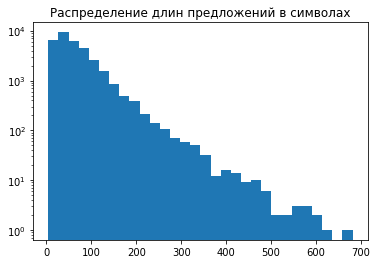

In [66]:
plt.hist([len(line) for line in quotes_rus], bins=30)
plt.title('Распределение длин предложений в символах')
plt.yscale('log');

In [67]:
#раpбиваем на чанки не более заданной длины, причем чанки должны состоять 
#из цельных предложений, а не кусков, чанки перекрывают друг друга со 
#со сдвигом в одно предложение
#если предложение длинне макс. длины чанка, оно отбрасывается
chunk_size = 300
all_chunks = []
sent_corpus = quotes_rus
for i in range(len(sent_corpus)):
    if len(sent_corpus[i]) <= chunk_size:
        all_chunks.append(sent_corpus[i])
    else:
        continue
    j = 1
    while i+j < len(sent_corpus) and len(all_chunks[-1] + ' ' + sent_corpus[i+j]) <= chunk_size:
        all_chunks[-1] = all_chunks[-1] + ' ' + sent_corpus[i+j]
        j += 1

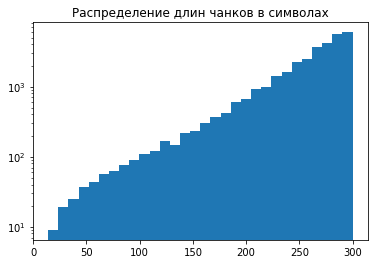

In [68]:
plt.hist([len(line) for line in all_chunks], bins=30)
plt.title('Распределение длин чанков в символах')
plt.yscale('log');

In [69]:
all_chunks[10:20]

['Бойся равнодушных. Больше света! Браки совершаются на небесах. Братья по разуму. Будущее невозможно предвидеть, но можно изобрести. Будь готов! – Всегда готов! Будьте бдительны! Буря в стакане воды. Бывали хуже времена, но не было подлей. Бывшее сделать небывшим,. В борьбе обретешь ты право свое.',
 'Больше света! Браки совершаются на небесах. Братья по разуму. Будущее невозможно предвидеть, но можно изобрести. Будь готов! – Всегда готов! Будьте бдительны! Буря в стакане воды. Бывали хуже времена, но не было подлей. Бывшее сделать небывшим,. В борьбе обретешь ты право свое.',
 'Браки совершаются на небесах. Братья по разуму. Будущее невозможно предвидеть, но можно изобрести. Будь готов! – Всегда готов! Будьте бдительны! Буря в стакане воды. Бывали хуже времена, но не было подлей. Бывшее сделать небывшим,. В борьбе обретешь ты право свое. В окопах нет атеистов.',
 'Братья по разуму. Будущее невозможно предвидеть, но можно изобрести. Будь готов! – Всегда готов! Будьте бдительны! Буря в

In [70]:
np.random.shuffle(all_chunks)

TRAIN_SPLIT = int(len(all_chunks) * 0.7)
train_texts = all_chunks[:TRAIN_SPLIT]
test_texts = all_chunks[TRAIN_SPLIT:]

print('Размер обучающей выборки', len(train_texts))
print('Размер валидационной выборки', len(test_texts))

Размер обучающей выборки 22981
Размер валидационной выборки 9850


In [71]:
if not LOAD_SAVED_MODELS_MODE:
    !mkdir ./stepik-dl-nlp/
    !mkdir ./stepik-dl-nlp/datasets/

    # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
    TRAIN_TEXTS_FILENAME = './stepik-dl-nlp/datasets/quotes_rus.txt'
    save_texts_to_file(train_texts, TRAIN_TEXTS_FILENAME)
    
    !mkdir ./stepik-dl-nlp/models/
    BPE_MODEL_FILENAME = './stepik-dl-nlp/models/quotes_rus.yttm'

    # data: string, path to file with training data
    # model: string, path to where the trained model will be saved
    # vocab_size: int, number of tokens in the final vocabulary
    # coverage: float, fraction of characters covered by the model. Must be in the range [0, 1]. A good value to use is about 0.9999.
    # n_threads: int, number of parallel threads used to run. If -1 is passed, then all available threads are going to be used. 
    #     Note that the number of threads is limited by 8 (see benchmark).
    # pad_id: int, reserved id for padding
    # unk_id: int, reserved id for unknown symbols
    # bos_id: int, reserved id for begin of sentence token
    # eos_id: int, reserved id for end of sentence token
    yttm.BPE.train(data=TRAIN_TEXTS_FILENAME, vocab_size=1000, model=BPE_MODEL_FILENAME);
else:
    #берем модель из предыдущего ноутбука
    BPE_MODEL_FILENAME = '/kaggle/input/stepik-nn-and-nlp-4-6-final-transformer-and-sa/stepik-dl-nlp/models/quotes_rus.yttm'

mkdir: cannot create directory ‘./stepik-dl-nlp/’: File exists
mkdir: cannot create directory ‘./stepik-dl-nlp/datasets/’: File exists
mkdir: cannot create directory ‘./stepik-dl-nlp/models/’: File exists


Training parameters
  input: ./stepik-dl-nlp/datasets/quotes_rus.txt
  model: ./stepik-dl-nlp/models/quotes_rus.yttm
  vocab_size: 1000
  n_threads: 2
  character_coverage: 1
  pad: 0
  unk: 1
  bos: 2
  eos: 3

reading file...
learning bpe...
number of unique characters in the training data: 167
number of deleted characters: 0
number of unique characters left: 167
model saved to: ./stepik-dl-nlp/models/quotes_rus.yttm


In [72]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [73]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о е а и т н с р в л д м к у . п ь я ы , б г ч з й ж ш х ю ц – щ ! В П Н С э К Б М О Д Т И ф … Е Г Р А ? Я Ч > < / Л « » - : У З ; Х Э Ж — 1 Ф Ц ) ( Ш 9 ъ ё 0 e 8 o C i ° I s 2 a n 5 t u 6 r 4 3 ➞ 7 ́ Ю l m d ] V [ Щ X c Й p v b % Ь h g Ы N і P x f L A " ó k M ’ G H ї T R B № S F E ♦ “ é j W O = € Q J ” ´ z + є Ё à „ q K á Z Y ü * ' ▁н ст ▁п ▁в ▁с то ра ен ет ро ▁и ко но ▁д ли го ▁о ▁м ▁б ▁не ть ре ка ▁по во ел ▁на ▁ч ер ни на ва да ны ▁т ри ▁з ем ся ▁– ло ▁у ла ль ит ▁В ки ов ▁П ▁ко ▁Н ▁е ▁к ти ди ени ▁то ▁С ру ▁за сть ле се ▁что не ми ▁мо ▁бы ▁ж ▁ра ▁до бо хо ▁Б ▁во ▁К ▁ст ▁М ▁а ▁э ▁ка лю ви ма ес по ше ля ▁г до ▁про та ▁со ест ши ▁от ▁все уд ▁го ча ▁бо лу ей ▁ни ▁это мо га ▁Д сти ▁О е. ▁вы ▁Т ове ют ▁И ры ▁при ▁я е, ать гда ци чи елове сли сто ду ку ель ста ну ▁об ▁но ги ▁Г м. ный ▁лю ▁Е ▁сво ▁Р ере му я. ▁По ез ▁из де рав ▁Бо па щи ▁та ▁А бы ▁челове ется си ▁пре за шь вы его ▁жи ень ▁ми ят ▁Я ▁хо <… <…> ▁как ды ▁Ч ▁<…> сь м, ▁/ ша ств ▁ре ▁ве жно енно еб жи

In [74]:
print(tokenizer.encode(train_texts[:1], bos=True, eos=True))

[[2, 373, 254, 226, 255, 22, 459, 194, 4, 288, 10, 491, 373, 254, 10, 638, 848, 253, 280, 182, 252, 20, 606, 14, 289, 474, 193, 280, 4, 102, 287, 191, 254, 10, 638, 848, 253, 280, 51, 19, 373, 334, 184, 330, 255, 22, 540, 26, 183, 232, 239, 225, 316, 373, 26, 12, 319, 174, 14, 209, 227, 359, 45, 828, 243, 65, 105, 16, 243, 470, 373, 261, 14, 306, 239, 186, 241, 261, 680, 222, 318, 7, 16, 227, 415, 32, 594, 274, 172, 402, 373, 575, 414, 30, 205, 449, 688, 192, 182, 198, 212, 306, 19, 373, 8, 499, 285, 226, 415, 532, 225, 667, 717, 19, 373, 183, 177, 288, 6, 523, 339, 195, 187, 398, 641, 282, 3]]


In [75]:
train_token_ids = tokenizer.encode(train_texts, bos=True, eos=True)
test_token_ids = tokenizer.encode(test_texts, bos=True, eos=True)

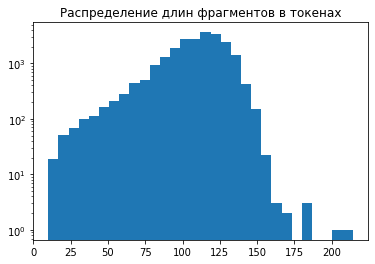

In [76]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

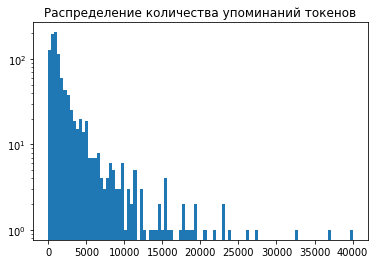

In [77]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=100)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [78]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 1


In [79]:
CHUNK_LENGTH = max(map(len,train_token_ids))
print('CHUNK_LENGTH = {}'.format(CHUNK_LENGTH))

#формируем датасеты на основе исходных последовательностей BPE (с разбросом длины примерно от 40 до 160), 
#на примере запроса одного элемента, они будут возвращать:
#2 шт. numpy array (seed_part, target_part), длины 80, состоящие из id токенов, где токены в target_part,
#смещены на 1 вперед, относительно seed_part, кроме того:
# - если длина изначальной BPE последовательности > CHUNK_LENGTH, то итоговая последовательность вырезается
#   в объеме CHUNK_LENGTH из рандомного места (не сначала)
# - если длина изначальной BPE последовательности < CHUNK_LENGTH, то берется вся исходная и добивается справа 
#   паддингами до длины CHUNK_LENGTH
train_dataset = LanguageModelDataset(train_token_ids,
                                     chunk_length=CHUNK_LENGTH)
test_dataset = LanguageModelDataset(test_token_ids,
                                    chunk_length=CHUNK_LENGTH)

CHUNK_LENGTH = 214


In [80]:
torch_transf_model = LanguageModel(tokenizer.vocab_size(),
                                   256, #EmbSize
                                   BatchFirstTransformerEncoder(
                                       nn.TransformerEncoderLayer(
                                           d_model=256, #EmbSize
                                           nhead=16,
                                           dim_feedforward=512,
                                           dropout=0.1),
                                       num_layers=3),
                                   emb_dropout=0.1)
print('Количество параметров', get_params_number(torch_transf_model))

Количество параметров 2094312


In [81]:
if not LOAD_SAVED_MODELS_MODE:
    (best_val_loss,
     best_torch_transf_model) = train_eval_loop(torch_transf_model,
                                                train_dataset,
                                                test_dataset,
                                                lm_cross_entropy,
                                                lr=2e-3,
                                                epoch_n=20,
                                                batch_size=256,
                                                device='cuda',
                                                early_stopping_patience=20,
                                                max_batches_per_epoch_train=1000,
                                                max_batches_per_epoch_val=1000,
                                                lr_scheduler_ctor=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim,
                                                                                  patience=10,
                                                                                  factor=0.5,
                                                                                  verbose=True),
                                                no_calculate_accuracy = True)

    # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
    torch.save(best_torch_transf_model.state_dict(), './stepik-dl-nlp/models/quotes_rus.pth')

#     # Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
#     torch_transf_model.load_state_dict(torch.load('./stepik-dl-nlp/models/war_and_peace_torch_transf_best_v2.pth'))
else:
    if GLOBAL_DEVICE == 'cuda':
        #Используем сохраненную в предыдущей версии ноутбука ("Save Version") модель
        torch_transf_model.load_state_dict(torch.load('/kaggle/input/stepik-nn-and-nlp-4-6-final-transformer-and-sa/stepik-dl-nlp/models/quotes_rus.pth'))
    else:
        #Используем сохраненную в предыдущей версии ноутбука ("Save Version") модель
        torch_transf_model.load_state_dict(torch.load('/kaggle/input/stepik-nn-and-nlp-4-6-final-transformer-and-sa/stepik-dl-nlp/models/quotes_rus.pth', 
                                                  map_location=torch.device('cpu')))

############## Start experiment with name: NoName ##############
Epoch =   1,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.6764, train = 5.7749   SAVE: True, Iters: 89, Time: 40.08s
Epoch =   2,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 4.1682, train = 4.4928   SAVE: True, Iters: 89, Time: 40.18s
Epoch =   3,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.7923, train = 4.1185   SAVE: True, Iters: 89, Time: 40.11s
Epoch =   4,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.5488, train = 3.8543   SAVE: True, Iters: 89, Time: 40.16s
Epoch =   5,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.3746, train = 3.6715   SAVE: True, Iters: 89, Time: 40.28s
Epoch =   6,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.2350, train = 3.5353   SAVE: True, Iters: 89, Time: 40.12s
Epoch =   7,   ACC: val = 0.0000, train = 0.0000    LOSS: val = 3.1259, train = 3.4268   SAVE: True, Iters: 89, Time: 40.23s
Epoch =   8,   ACC: val = 0.0000, train = 0.0000    LOSS: va

In [82]:
initial_sequences = [
    'Если ',
    'Был бы',
    'Не нужно ',
    'Всегда ',
    'Человек'
]

In [83]:
#подробный комментарий по работе приведен в коде GreedyGenerator
greedy_generator = GreedyGenerator(torch_transf_model, tokenizer, device=GLOBAL_DEVICE)

In [84]:
for init_seq in initial_sequences:
    print(greedy_generator(init_seq))

Если тебя не удерживает, что тебя удерживает, что тебя есть тебе не уподобные, а взрослых; если они не удержи
Был бы человек, но не смолкнул. Быть без невозможно. Быть безвознего. Быть безвознего. Быть безвознее, без
Не нужно, чтобы упадеть, чтобы упасть в том, чтобы управлять на него не управлять. Неужели Бог, но я не управляю
Всегда найдем на посту, но не в сидящем в поле, но и в то время и в то время и в то время и в то время и в то
Человек человеку не существует. Человек человеку – он не может позволить себе позволить себе позволить себе позволить себе позволи


In [85]:
my_beam_generator = myBeamGenerator(torch_transf_model, tokenizer, device=GLOBAL_DEVICE)

In [86]:
for init_seq in initial_sequences:
    print('{:-<100}'.format(init_seq))
    beam_gen_variants = my_beam_generator(init_seq,
                                       beamsize=20,
                                       max_steps_n=160,
                                       return_hypotheses_n=20,
                                       norm='sqrt_len')

    for score, pred_txt in beam_gen_variants:
        print('****')
        print(score)
        print(pred_txt)
        print()
    print()
    print()

Если -----------------------------------------------------------------------------------------------
****
4.857244154745574
Если хочешь. Если хочешь – / Если хочешь, / Если хочешь, / Если-нибудь по-настоящему. Если хочешь быть – / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищи!<EOS>

****
4.862518399330754
Если хочешь. Если хочешь – / Если хочешь, / Если хочешь, / Если-нибудь по-настоящему. Если хочешь быть – / Товарищ, / Товарищ, / Товарищи, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищи!<EOS>

****
4.883940830980041
Если хочешь. Если хочешь – / Если хочешь, / Если хочешь, / Если-нибудь по-настоящему. Если хочешь быть – / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Товарищ, / Тов